# Разработка модели для предсказания снижения покупательской активности

## Описание проекта





Для выполнения работы предоставляются четрые датасета.

1. Файл market_file.csv  содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Описание столбцов:

    - id — номер покупателя в корпоративной базе данных;
    - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»;
    - Тип сервиса — уровень сервиса, например «премиум» и «стандарт»;
    - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель;
    - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента;
    - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце;
    - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;
    - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
    - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев;
    - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
    - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца;
    - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта;
    - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
    

2. Файл market_money.csv содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Описание столбцов:

    - id — номер покупателя в корпоративной базе данных;
    - Период — название периода, во время которого зафиксирована выручка. Например: 'текущий_месяц' или 'предыдущий_месяц';
    - Выручка — сумма выручки за период.


3. Файл market_time.csv содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. Описание столбцов:

    - id — номер покупателя в корпоративной базе данных;
    - Период — название периода, во время которого зафиксировано общее время;
    - минут — значение времени, проведённого на сайте, в минутах.


4. Файл money.csv содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Содержание столбцов:

    - id — номер покупателя в корпоративной базе данных;
    - Прибыль — значение прибыли.


## Загрузка данных

Загрузка библиотек.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, RobustScaler, PolynomialFeatures)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             confusion_matrix, roc_auc_score, f1_score)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from optuna.integration import OptunaSearchCV
from optuna import distributions
import phik
import shap

Чтение csv файлов.

In [2]:
try:
    data_market_file = pd.read_csv('market_file.csv', sep=',')
except:
    data_market_file = pd.read_csv('/datasets/market_file.csv', sep=',')

In [3]:
try:
    data_market_money = pd.read_csv('market_money.csv', sep=',')
except:
    data_market_money = pd.read_csv('/datasets/market_money.csv', sep=',')

In [4]:
try:
    data_market_time = pd.read_csv('market_time.csv', sep=',')
except:
    data_market_time = pd.read_csv('/datasets/market_time.csv', sep=',')

In [5]:
try:
    data_money = pd.read_csv('money.csv', sep=';', decimal=',')
except:
    data_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

Функция для отображения информации о данных.

In [6]:
def show_info(df):
    print(df.info())
    return df.head()

In [7]:
show_info(data_market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Пропусков и несоответствия типов данных в датасете нет.

In [8]:
show_info(data_market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

Пропусков и несоответствия типов данных в датасете нет.

In [9]:
show_info(data_market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

Пропусков и несоответствия типов данных в датасете нет.

In [10]:
show_info(data_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Пропусков и несоответствия типов данных в датасете нет. Прибыль указана скорее всего в тысячах рублей, т.к. данные не соответствуют другим датафреймам.

## Предобработка данных

Поправим названия столбцов на более удобные.

In [11]:
data_market_file.columns = [
    'id', 'Покупательская_активность', 'Тип_сервиса',
    'Разрешить_сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
    'Длительность', 'Акционные_покупки', 'Популярная_категория',
    'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса', 'Страниц_за_визит'
]

In [12]:
show_info(data_market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

### Явные дубликаты

Проверим датасеты на наличие явных дубликатов.

In [13]:
data_market_file.duplicated().sum()

0

In [14]:
data_market_money.duplicated().sum()

0

In [15]:
data_market_time.duplicated().sum()

0

In [16]:
data_money.duplicated().sum()

0

В данных явных дубликатов нет.

### Неявные дубликаты

Проверим категориальные столбцы на наличие неявных дубликатов. Для поиска неявных дубликатов в категориальных столбцах напишем функцию.

In [17]:
def non_exact_duplicates(data):
    for column in data.select_dtypes(exclude='number'):
        print(f'Столбец "{column}": {data[column].unique()}')

In [18]:
non_exact_duplicates(data_market_file)

Столбец "Покупательская_активность": ['Снизилась' 'Прежний уровень']
Столбец "Тип_сервиса": ['премиум' 'стандартт' 'стандарт']
Столбец "Разрешить_сообщать": ['да' 'нет']
Столбец "Популярная_категория": ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [19]:
non_exact_duplicates(data_market_money)

Столбец "Период": ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [20]:
non_exact_duplicates(data_market_time)

Столбец "Период": ['текущий_месяц' 'предыдцщий_месяц']


В столбце "Тип сервиса" из датасета data_market_file есть опечатка. В датасете data_market_time есть опечатка в 'предыдцщий_месяц'. Поправим эти ошибки.

In [21]:
data_market_file.loc[data_market_file['Тип_сервиса'] == 'стандартт', 'Тип_сервиса'] = 'стандарт'

In [22]:
data_market_time.loc[data_market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

In [23]:
non_exact_duplicates(data_market_time)

Столбец "Период": ['текущий_месяц' 'предыдущий_месяц']


### Вывод

Все проблемы в данных были исправлены.

## Исследовательский анализ данных

### Функции для построения графиков

In [24]:
# Функция для построения гистограммы и диаграммы размаха 
# Принимает на вход столбец датафрейма, заголовок и подпись оси x

def hist_box_plot(series, bins, title='', x_lable=''):
    
    # Создаем рисунок из двух графиков с общей осью x
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 7))
    
    # Задаем первый график - гистограмма
    plot_hist = ax1.hist(
        series,    
        bins=bins, 
        edgecolor='black'
        )
    
    # Вычисляем и добавляем на график линию среднего значения
    ax1.vlines(
        x=series.mean(), 
        colors='red', 
        ymin=0, 
        ymax=plot_hist[0].max(), 
        label='Среднее')
    
    # Вычисляем и добавляем на график линию медианного значения
    ax1.vlines(
        x=series.median(), 
        colors='red', 
        ymin=0, 
        ymax=plot_hist[0].max(), 
        linestyles='--', 
        label='Медиана')
    

    # Задаем параметры гистограммы, заголовок, подпись оси y, сетка 
    ax1.set_ylabel('Часота', fontsize=12)
    ax1.set_title('Гистограмма')
    ax1.grid(True)
    
    # Задаем отображение легенды, чтобы отображалась легенда линий среднего и медианы
    ax1.legend()
    
    # Строим второй график - диаграмму размаха
    ax2.boxplot(series, vert=False)
    
    # Задаем параметры 
    plt.xlabel(x_lable, fontsize=12)
    plt.grid(True)
    plt.yticks([])
    ax2.set_ylabel('Диаграмма размаха', fontsize=12)

    # Выводим общий заголовок
    fig.suptitle(title)
    
    # Выводим графики на экран
    plt.show()
    
    # Выводим на экран статистику столбца
    print(series.describe())

In [25]:
# Функция принимает столбец с категориальным признаком и название графика
def cat_plot(series, title='', x_label='', rot=0):
    
    
    if len(series.unique()) == 2:
    # Для признаков с двумя строится круговая диаграмм
    # Считаем количество каждой категории и строим круговую диаграмму
        series.value_counts().plot(
            kind='pie',
            ylabel='',
            legend=False,
            autopct='%.1f%%',
            figsize=(7, 7),
            fontsize=14,
            rot=rot,
            )
    
    # Для признаков, у которых больше двух категорий строится столбчатая диаграмма
    else:
        series.value_counts().sort_values().plot(
            kind='bar',
            ylabel='Количество',
            legend=False,
            figsize=(7, 7),
            rot=rot,
            grid=True,
            )
        
    
    # Задаем заголовок графика
    plt.title(title, fontsize=12)
    
    # Выводим график на экран
    plt.show()

### Анализ количественных признаков data_market_file

In [26]:
show_info(data_market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

#### Маркетинговая активность за последние 6 месяцев

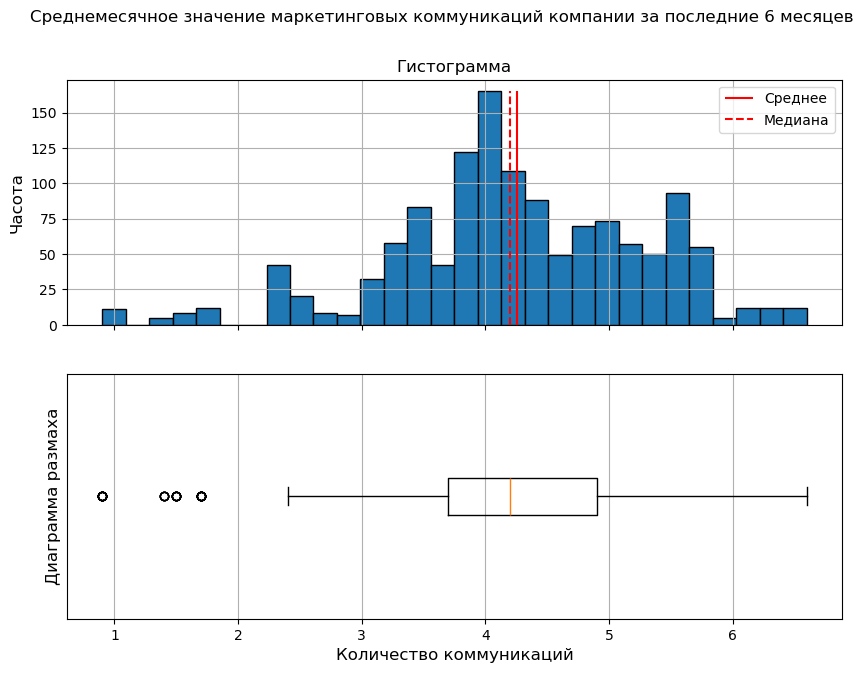

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


In [27]:
hist_box_plot(
    data_market_file['Маркет_актив_6_мес'], 
    bins=30, 
    title='Среднемесячное значение маркетинговых коммуникаций компании за последние 6 месяцев', 
    x_lable='Количество коммуникаций'
)

В среднем за последние пол года на одного клиента компании приходилось 4,2 маркетинговых взаимодействия. Распределение отдаленно напоминает нормальное, каких-то анамалий в этом столбец нет.

#### Маркетинговая активность за текущий месяц

In [28]:
data_market_file['Маркет_актив_тек_мес'].unique()

array([5, 4, 3], dtype=int64)

В данном столбце всего 3 значения, поэтому для его визуализации используем столбчатую диаграмму.

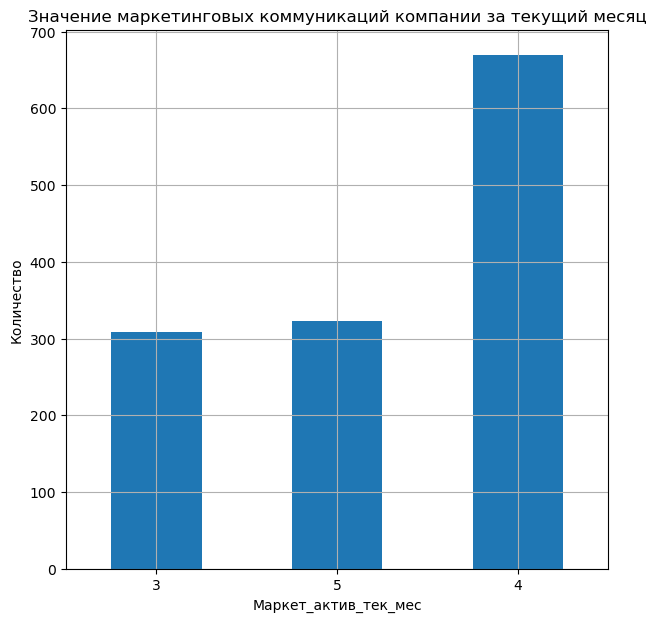

In [29]:
cat_plot(
    data_market_file['Маркет_актив_тек_мес'],
    title='Значение маркетинговых коммуникаций компании за текущий месяц',
    x_label='Количество коммуникаций'
)

#### Количество дней с момента регистрации

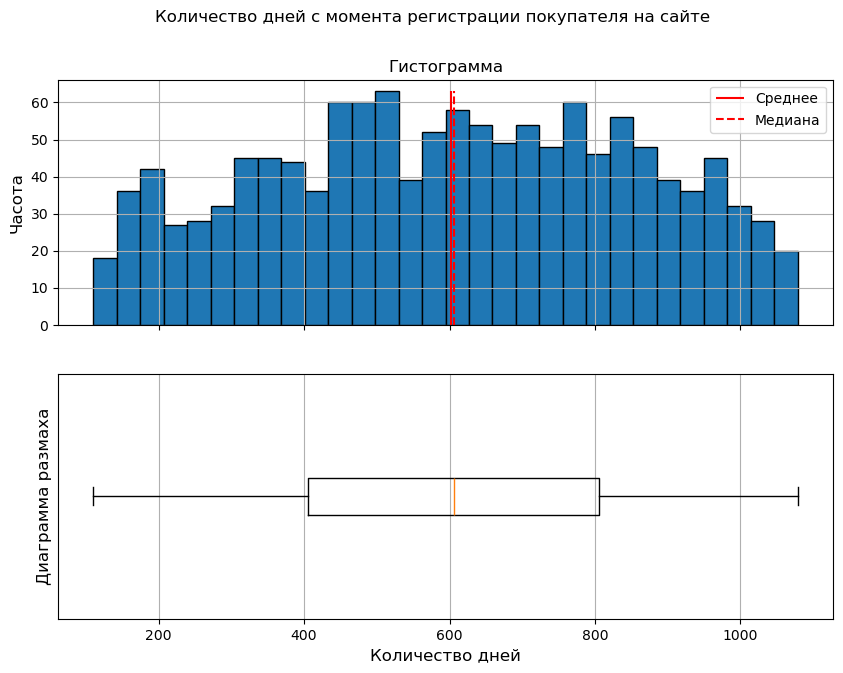

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64


In [30]:
hist_box_plot(
    data_market_file['Длительность'], 
    bins=30, 
    title='Количество дней с момента регистрации покупателя на сайте', 
    x_lable='Количество дней'
)

Самый "новый" пользователь зарегестрировался 110 дней назад. По этим данным видно, что данные даны по покупателям, которые пользуются сервисом от 3 месяцев до 3 лет.

#### Доля покупок по акции

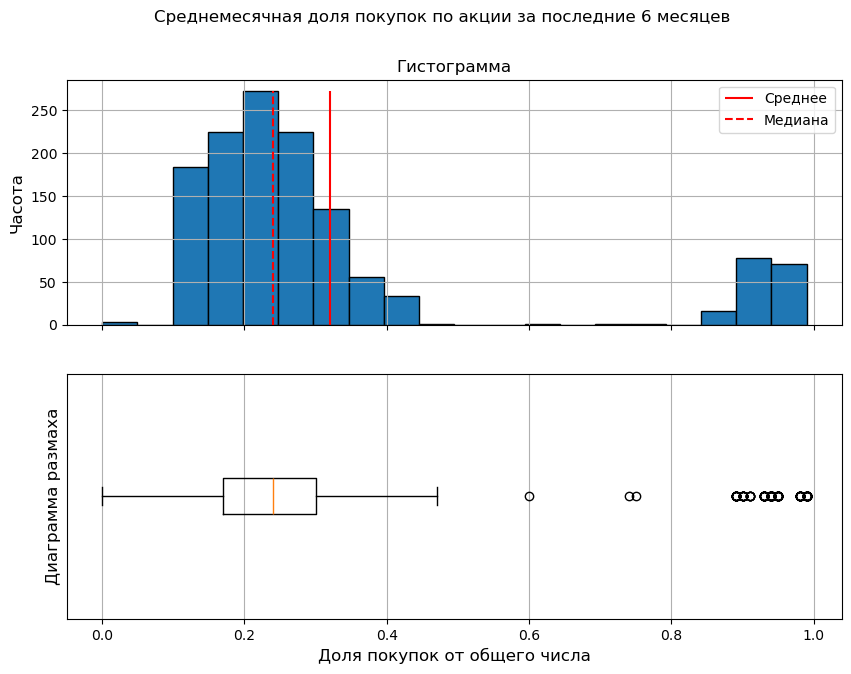

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


In [31]:
hist_box_plot(
    data_market_file['Акционные_покупки'], 
    bins=20, 
    title='Среднемесячная доля покупок по акции за последние 6 месяцев', 
    x_lable='Доля покупок от общего числа'
)


На графике можно выделить 2 группы покупателей. Первая группа рассредоточено вокруг медианного значения в 0,24, это обычные покупатели, которые берут товары, в меньшей степени ориентриуясь на акции. Вторая группа на графиках справа, это группа людей, у которой около 90% процентов покупок приходится на акционные товары.

#### Средний просмотр категорий за визит

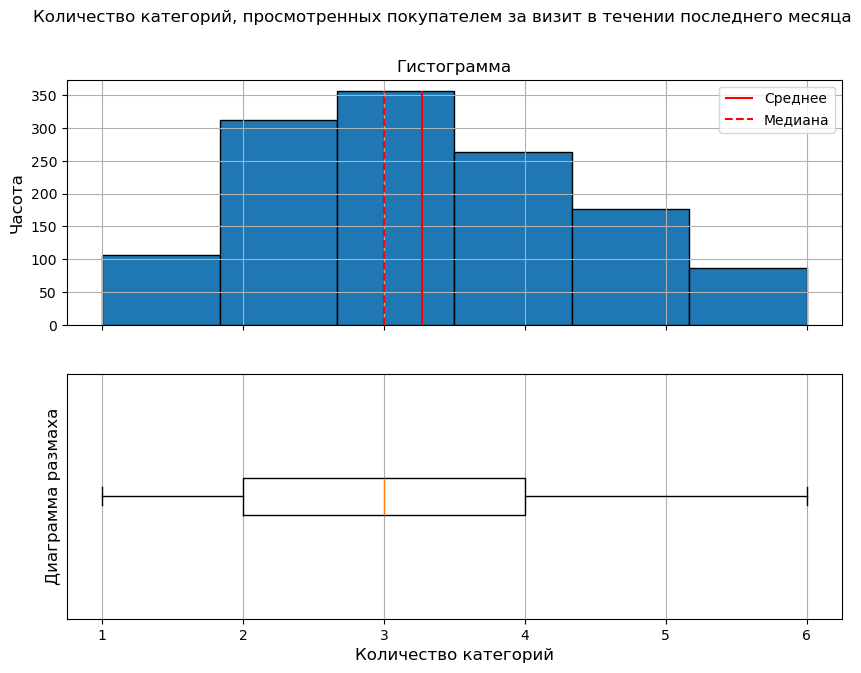

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


In [32]:
hist_box_plot(
    data_market_file['Средний_просмотр_категорий_за_визит'], 
    bins=6, 
    title='Количество категорий, просмотренных покупателем за визит в течении последнего месяца', 
    x_lable='Количество категорий'
)

В среднем покупатель просматривал около 3 категорий за визит в течении последнего месяца.

#### Неоплаченные продукты штук квартал

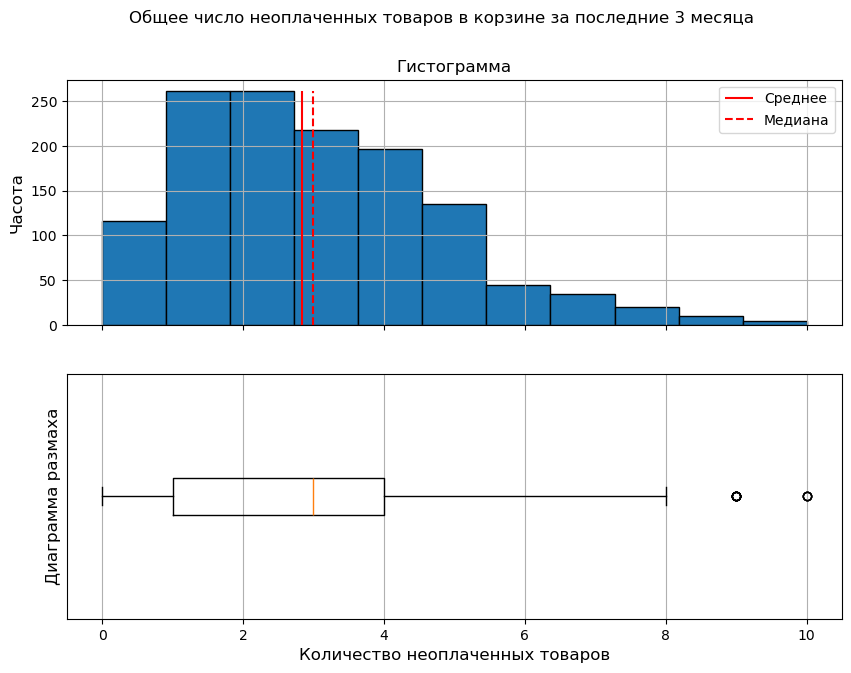

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


In [33]:
hist_box_plot(
    data_market_file['Неоплаченные_продукты_штук_квартал'], 
    bins=11, 
    title='Общее число неоплаченных товаров в корзине за последние 3 месяца', 
    x_lable='Количество неоплаченных товаров'
)

В среднем у покупателя в корзине лежит 3 неоплаченных товара, но у некоторых это значение доходит и до 10. Скорее всего они там лежат в ожидании скидок.

#### Ошибка сервиса

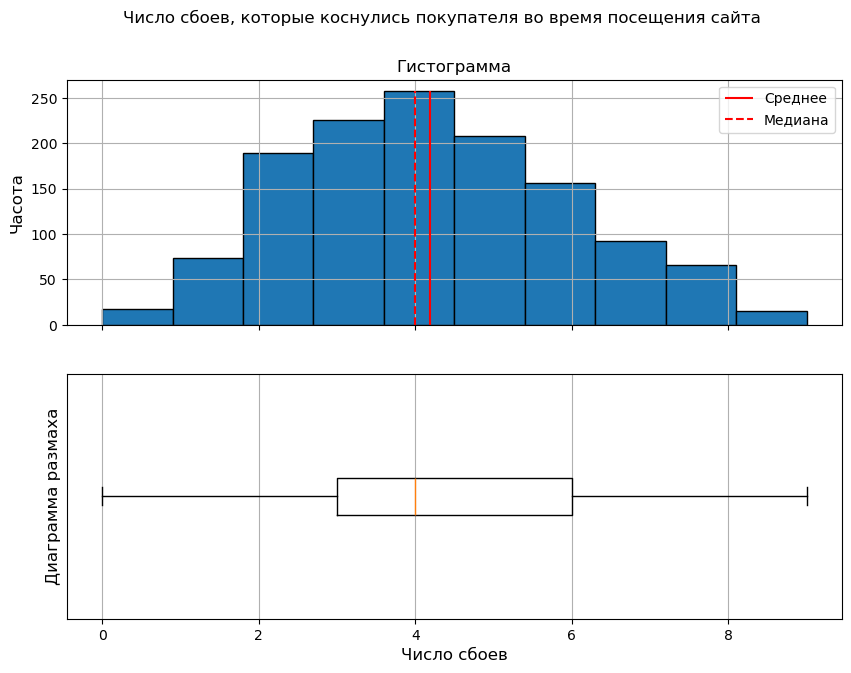

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64


In [34]:
hist_box_plot(
    data_market_file['Ошибка_сервиса'], 
    bins=10, 
    title='Число сбоев, которые коснулись покупателя во время посещения сайта', 
    x_lable='Число сбоев'
)

Пользователи сталкивались вплоть до 9 ошибок во время посещений сайта. Само распределение ошибок является нормальным со средним в 4,2 ошибки на пользователя.

#### Страниц за визит

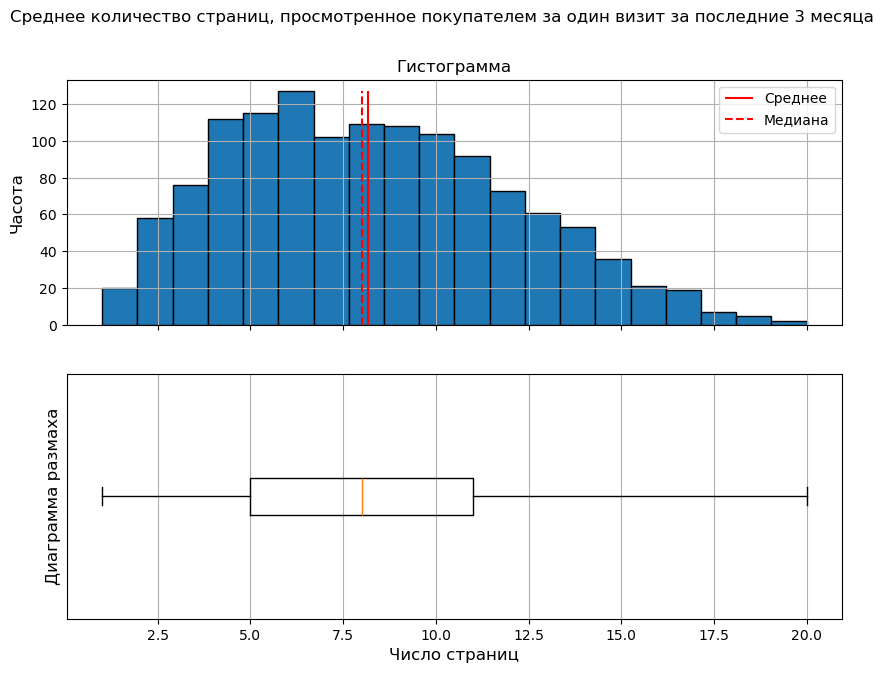

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64


In [35]:
hist_box_plot(
    data_market_file['Страниц_за_визит'], 
    bins=20, 
    title='Среднее количество страниц, просмотренное покупателем за один визит за последние 3 месяца', 
    x_lable='Число страниц'
)

В среднем покупатель просматривает 8 страниц за свой визит, но иногда это число доходит и до 20.

### Анализ категориальных признаков data_market_file

#### Покупательская активность

Покупательская активность - целевой признак, который необходимо предсказать в рамках данной работы.

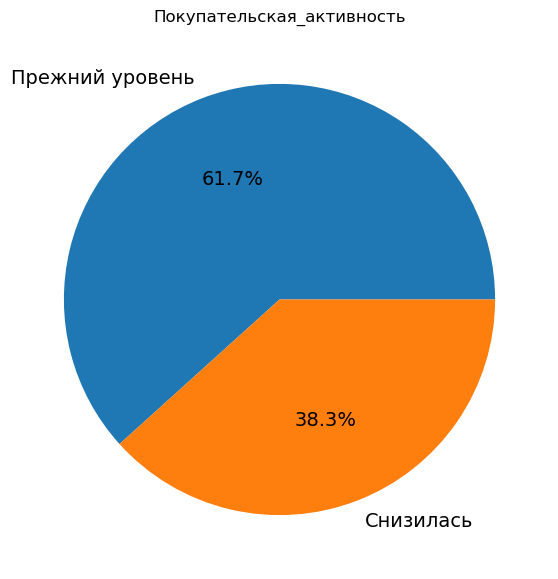

In [36]:
cat_plot(
    data_market_file['Покупательская_активность'],
    title='Покупательская_активность',
)

Почти 40% пользователей сервиса снизили свою покупательскую активность. Явно видно, что у сервиса есть проблемы.

#### Тип сервиса

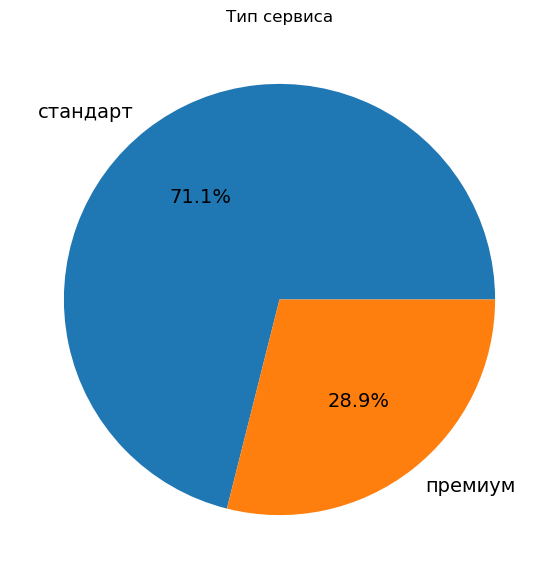

In [37]:
cat_plot(
    data_market_file['Тип_сервиса'],
    title='Тип сервиса',
)

29% пользователей интернет-магазина пользуются премиальным типом сервиса.

#### Разрешить сообщать

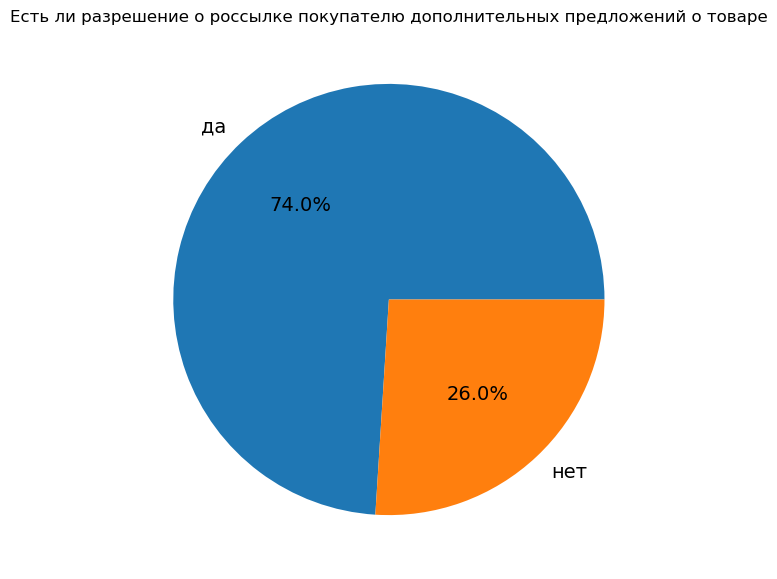

In [38]:
cat_plot(
    data_market_file['Разрешить_сообщать'],
    title='Есть ли разрешение о россылке покупателю дополнительных предложений о товаре',
)

#### Популярная категория

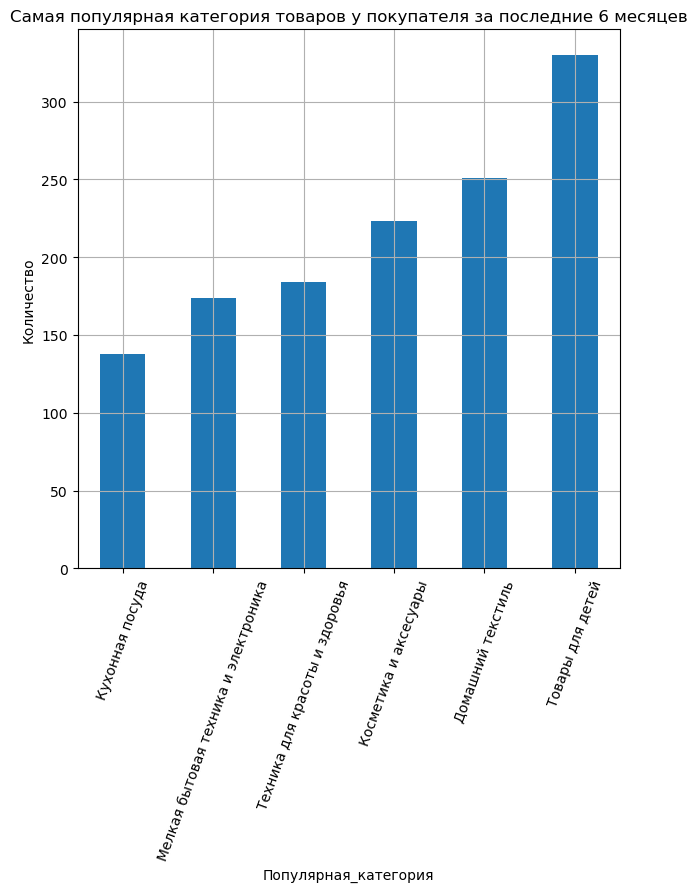

In [39]:
cat_plot(
    data_market_file['Популярная_категория'],
    title='Самая популярная категория товаров у покупателя за последние 6 месяцев',
    rot=70,
)

Самая популярная категория у покупателей - товары для детей, наименее популярная - кухонная посуда.

### Анализ количественных признаков data_market_money

In [40]:
show_info(data_market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

#### Выручка

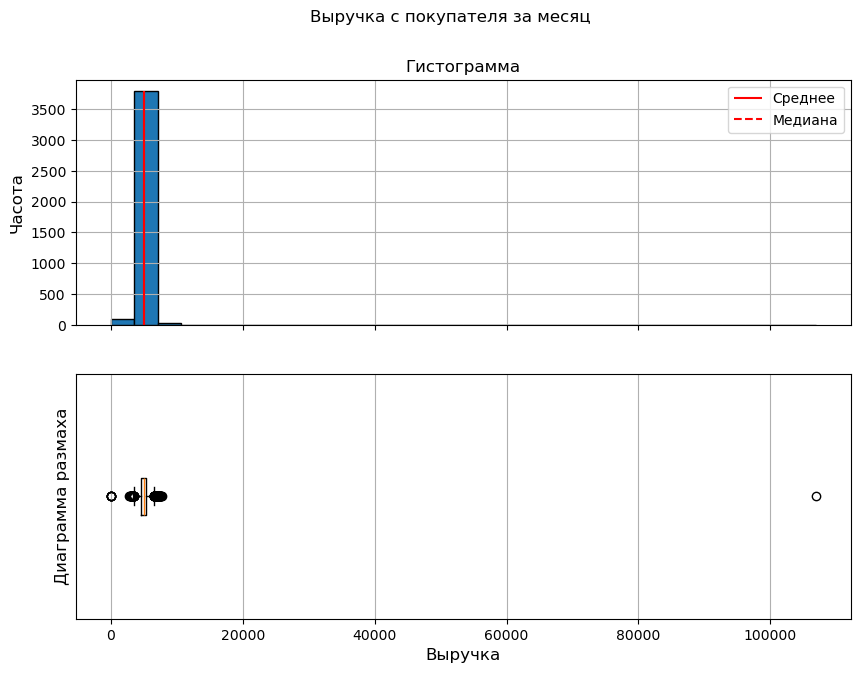

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


In [41]:
hist_box_plot(
    data_market_money['Выручка'], 
    bins=30, 
    title='Выручка с покупателя за месяц', 
    x_lable='Выручка'
)

На графиках видно аномальное значение, которое превышает 100000. Посмотрим на него.

In [42]:
data_market_money.loc[data_market_money['Выручка'] > 20000]

id         Период   Выручка
98  215380  текущий_месяц  106862.2

Один покупатель, который потратил 107 тысяч на покупки в этом месяце. Посмотрим на его активность в другие периоды.

In [43]:
data_market_money.loc[data_market_money['id'] == 215380]

id               Период   Выручка
96  215380  препредыдущий_месяц    5051.0
97  215380     предыдущий_месяц    6077.0
98  215380        текущий_месяц  106862.2

Посмотрим на общую выручку от этого покупателя.

In [44]:
data_money.loc[data_money['id'] == 215380]

id  Прибыль
32  215380     3.88

In [45]:
data_market_file.loc[data_market_file['id'] == 215380]

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
32  215380                 Снизилась     премиум                нет   

    Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
32                 1.7                     4           637               0.94   

              Популярная_категория  Средний_просмотр_категорий_за_визит  \
32  Техника для красоты и здоровья                                    3   

    Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
32                                   2               4                 7

Не похоже, что это аномальное значение правдиво. Заменим его средним значеним и заного пострим графики.

In [46]:
data_market_money.loc[data_market_money['id'] == 215380, 'Выручка'] = data_market_money['Выручка'].mean()

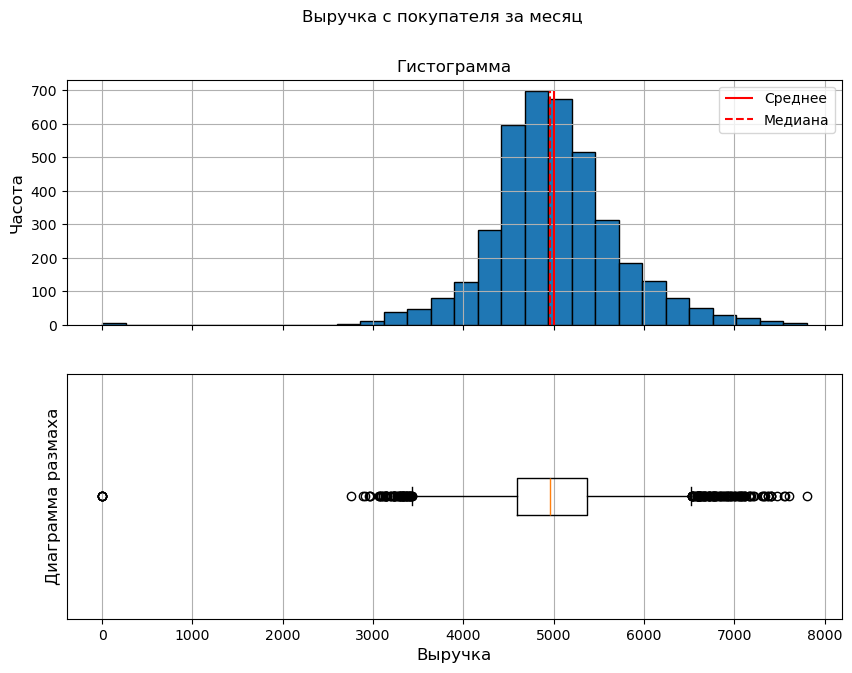

count    3900.000000
mean     4999.308074
std       706.698435
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5362.625000
max      7799.400000
Name: Выручка, dtype: float64


In [47]:
hist_box_plot(
    data_market_money['Выручка'], 
    bins=30, 
    title='Выручка с покупателя за месяц', 
    x_lable='Выручка'
)

В среднем один покупатель приносит 5000 рублей выручки.

### Анализ категориальных признаков признаков data_market_money

#### Период

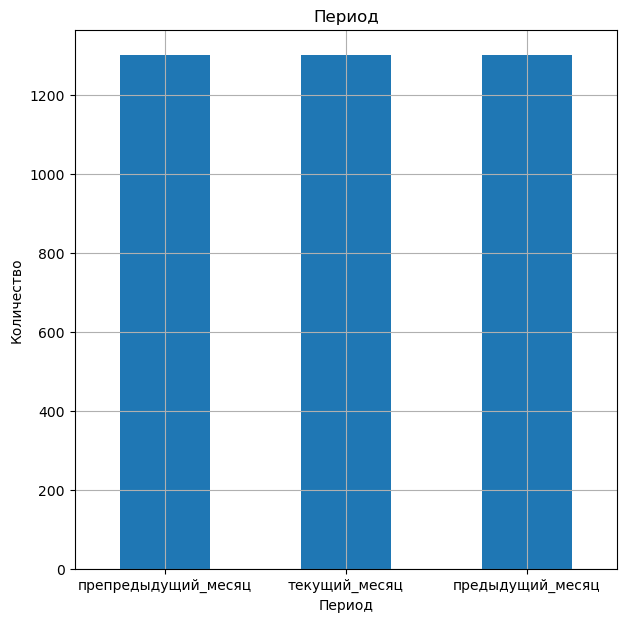

In [48]:
cat_plot(
    data_market_money['Период'],
    title='Период',
)

О каждом пользователе есть записи в датасете за 3 месяца. Данные соответствуют ожиданиям.

### Средняя выручка за период

Интересно посмотреть, как менялась средняя выручка от покупателей в зависимости от месяца.

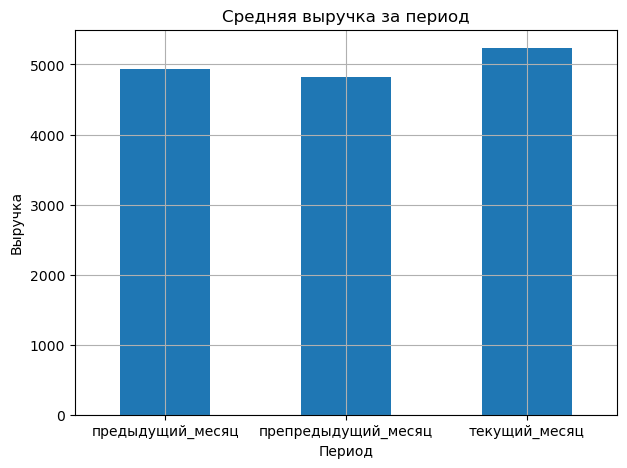

In [49]:
data_market_money.pivot_table(values='Выручка', index='Период', aggfunc='mean').plot(
    kind='bar',
    ylabel='Выручка',
    title='Средняя выручка за период',
    legend=False,
    figsize=(7, 5),
    grid=True,
    rot=0
)
plt.show()

Средняя выручка росла в каждом месяце, это хороший знак.

### Анализ количественных признаков data_market_time

In [50]:
show_info(data_market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

#### Минут

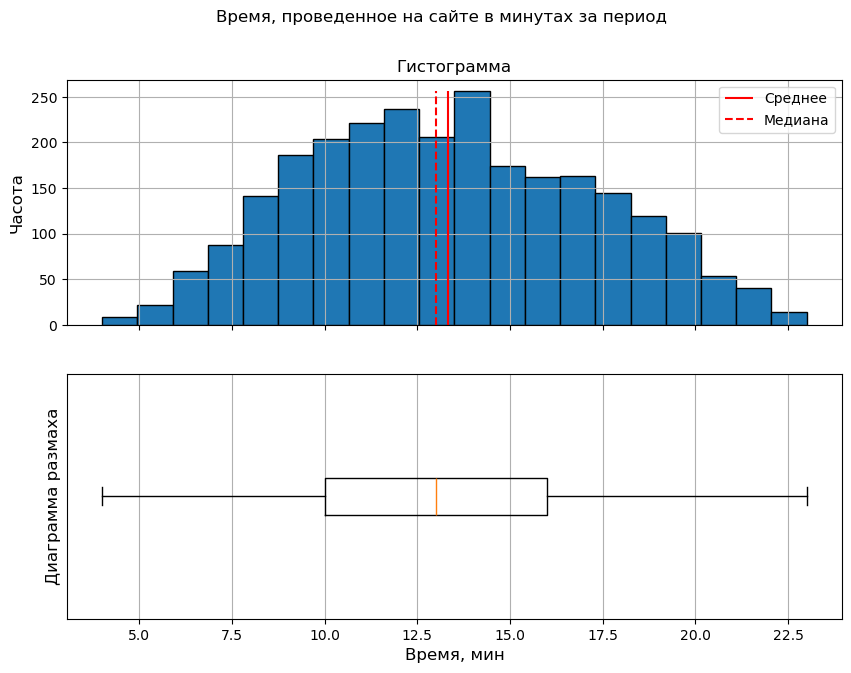

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


In [51]:
hist_box_plot(
    data_market_time['минут'], 
    bins=20, 
    title='Время, проведенное на сайте в минутах за период', 
    x_lable='Время, мин'
)

В среднем покупатель прводил на сайте 13 минут. Аномалий в данных нет.

### Анализ категориальных признаков признаков data_market_time

#### Период

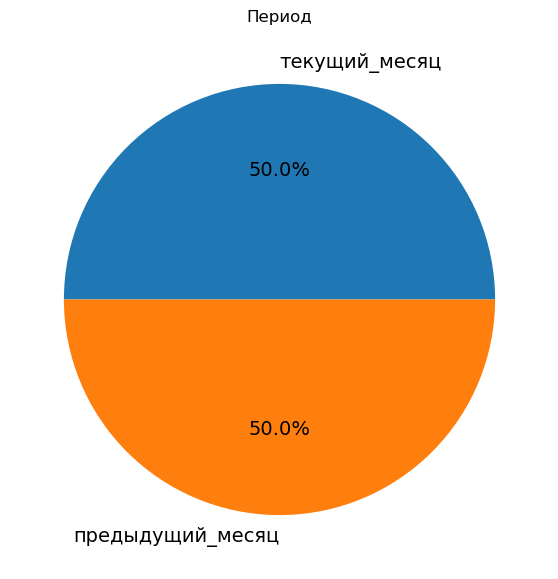

In [52]:
cat_plot(
    data_market_time['Период'],
    title='Период',
)

Для каждого покупателя есть данные за прошлый и текущий месяц, как и ожидалось.

### Анализ количественных признаков data_money

#### Прибыль

In [53]:
show_info(data_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

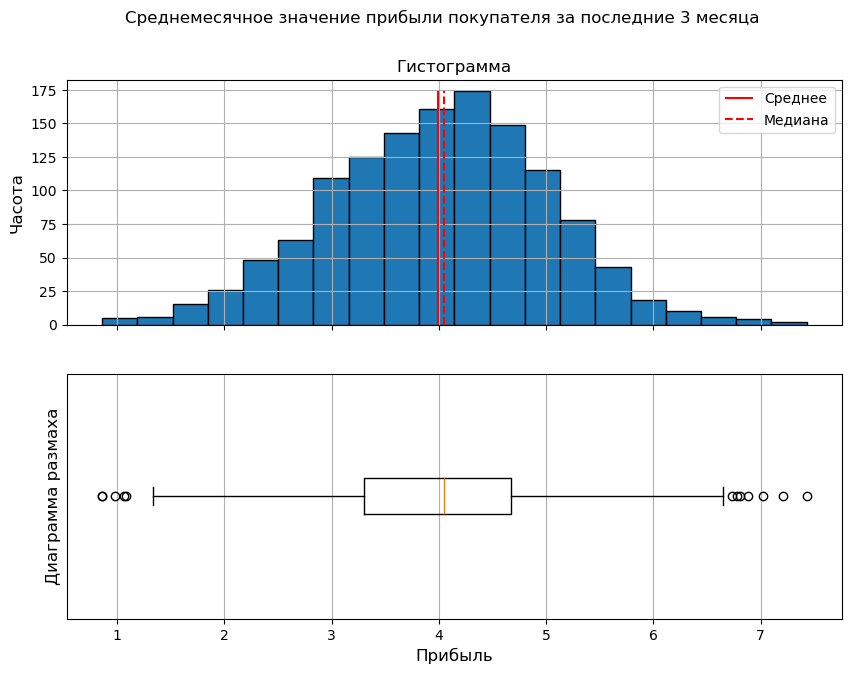

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


In [54]:
hist_box_plot(
    data_money['Прибыль'], 
    bins=20, 
    title='Среднемесячное значение прибыли покупателя за последние 3 месяца', 
    x_lable='Прибыль'
)

Судя по данным прибыль в данном датасете считается в тысячах рублей. В среднем пользователь приносит 4 тысячи рублей прибыли в месяц. Распередление явно выглядит как нормальное, аномальных значений в данных нет.

## Объединение таблиц

Объединим в одну таблицу датасеты data_market_file, data_market_money и data_market_time. В последних двух датасетах содержится информация за определенные периоды, выделим каждый период в этих датасетах в отдельный столбец.

In [55]:
data_market = data_market_file.copy()

In [56]:
for period in data_market_money['Период'].unique():
    data_market = data_market.merge(
        data_market_money.loc[data_market_money['Период'] == period, ['id', 'Выручка']],
        on='id',
        suffixes=['', '_' + period]
    )

In [57]:
for period in data_market_time['Период'].unique():
    data_market = data_market.merge(
        data_market_time.loc[data_market_time['Период'] == period, ['id', 'минут']],
        on='id',
        suffixes=['', '_' + period]
    )

In [58]:
show_info(data_market)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   Выручка  Выручка_текущий_месяц  Выручка_предыдущий_месяц  минут  \
0      0.0                 3293.1                       0.0     14   
1   4472.0                 4971.6                    5216.0     10   
2   4826.0                 5058.4                    5457.5     13   
3   4793.0                 6610.4                    6158.0     13   
4   4594.0                 5872.5                    5807.5     11   

   минут_предыдущий_месяц  
0                      13  
1                      12  
2                       8  
3                      11  
4                       8

In [59]:
data_market = data_market.rename(columns={'Выручка':'Выручка_препредыдущий_месяц', 'минут':'минут_текущий_месяц'})

In [60]:
show_info(data_market)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   Выручка_препредыдущий_месяц  Выручка_текущий_месяц  \
0                          0.0                 3293.1   
1                       4472.0                 4971.6   
2                       4826.0                 5058.4   
3                       4793.0                 6610.4   
4                       4594.0                 5872.5   

   Выручка_предыдущий_месяц  минут_текущий_месяц  минут_предыдущий_месяц  
0                       0.0                   14                      13  
1                    5216.0                   10                      12  
2                    5457.5                   13                       8  
3                    6158.0                   13                      11  
4                    5807.5                   11                       8

### Вывод

Таблицы успешно объединены.

## Корреляционный анализ

### Матрицы корреляции и диаграмм рассеяния

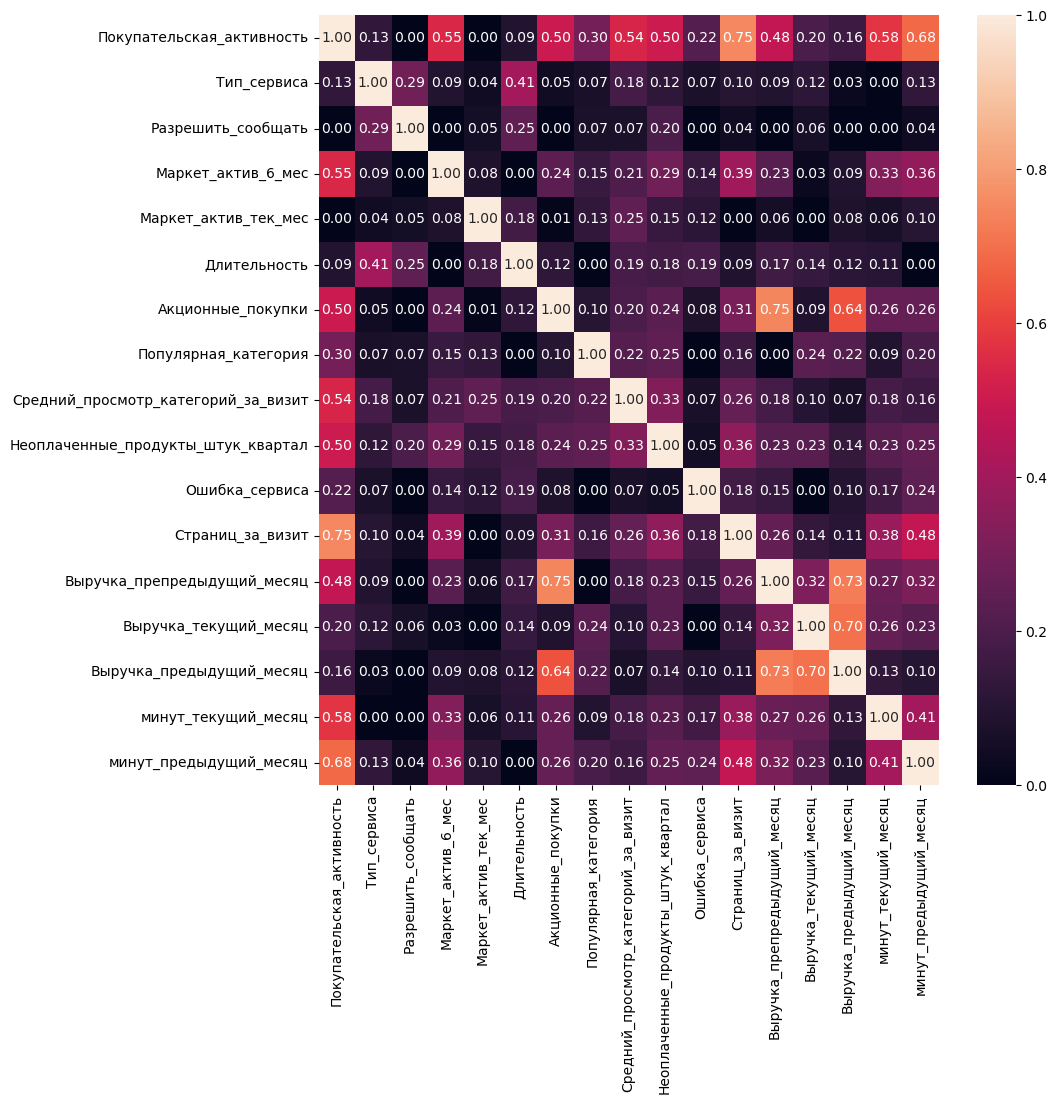

In [61]:
fig = sns.heatmap(data_market.drop('id', axis='columns').phik_matrix(
    interval_cols=data_market.drop('id', axis='columns').select_dtypes(include='number').columns), 
    annot=True, 
    fmt='.2f')
fig.figure.set_size_inches(10, 10)

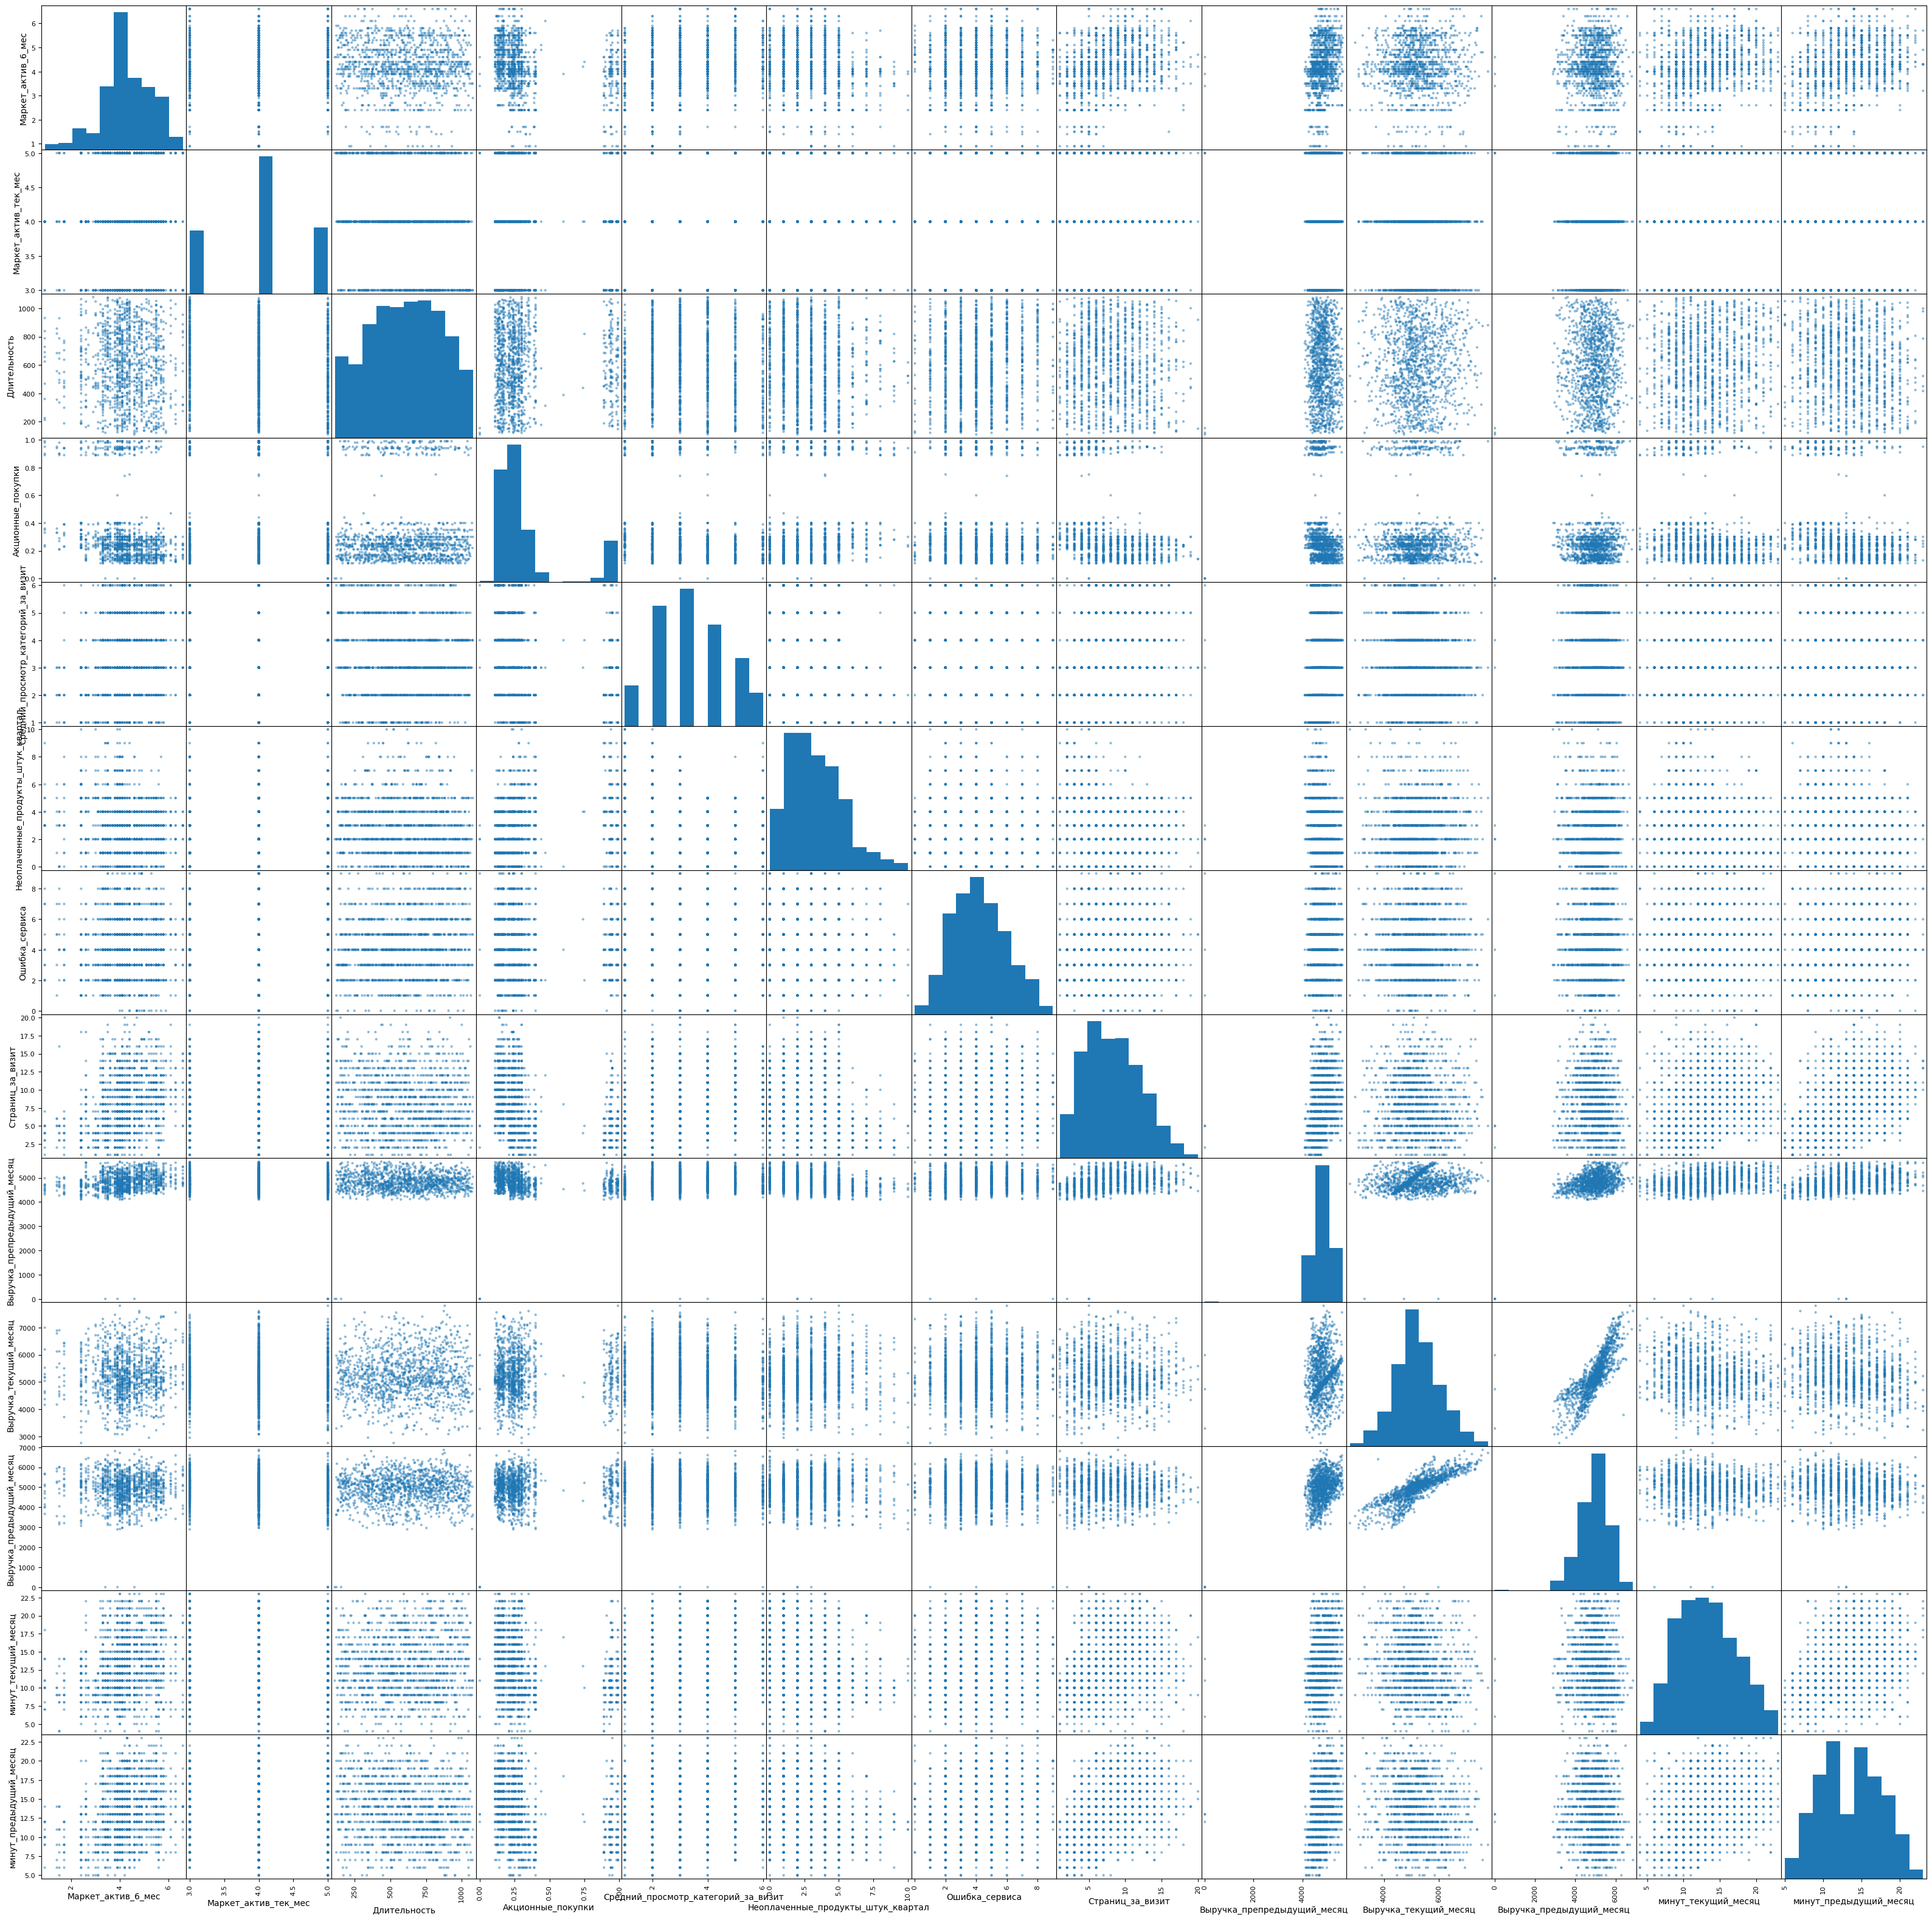

In [62]:
pd.plotting.scatter_matrix(data_market.drop('id', axis='columns'), figsize=(40, 40))
plt.show()

#### Вывод

Между признаками нет корреляции, превышающей 0,75. Соответственно можно говорит о том, что в признаках нет какой-либо мультиколлинеарности. Для обучения модели подходят все признаки, наименее полезные признаки будут убраны из обучения модели потом, в ходе анализа важности признаков.

## Пайплайн

Разобьем данные на тренирововчную и тестовую выборки.

In [63]:
RANDOM_STATE = 113
TEST_SIZE = 0.25

Закодируем целевой признак, где 1 будет говорить о снизившейся покупательской активности.

In [64]:
data_market['Покупательская_активность'] = data_market['Покупательская_активность'].apply(
    lambda x: 1 if x=='Снизилась' else 0)

In [65]:
data_market = data_market.rename(
    columns={'Покупательская_активность': 'Покупательская_активность_снизилась'}
)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(['id', 'Покупательская_активность_снизилась'], axis='columns'),
    data_market['Покупательская_активность_снизилась'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data_market['Покупательская_активность_снизилась']
)

Разобьем столбцы по категориям, для последующего кодирования.

In [67]:
ohe_columns = [
    'Тип_сервиса',
    'Разрешить_сообщать'    
]
ord_columns = [
    'Популярная_категория'
]
num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_препредыдущий_месяц',
    'Выручка_текущий_месяц',
    'Выручка_предыдущий_месяц',
    'минут_текущий_месяц',
    'минут_предыдущий_месяц'
]

In [68]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False)
        )
    ]
)

In [69]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [70]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [71]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
]) 

In [72]:
param_grid = [

    # словарь параметров модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'models__leaf_size': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    # словарь параметров  для DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 17),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь параметров для модели SVC
    {
        'models': [SVC(random_state=RANDOM_STATE, cache_size=10000)],
        'models__kernel': ['rbf', 'linear', 'poly'],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь параметров для модели LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

Запустим поиск лучшей модели для поставленной задачи. В качестве метрики выберем ROC-AUC. Эта метрика отражает отношение TPR к FPR, тем самым лучшей будет модель, которая чаще верно предсказывает значение класса 1 и реже присваивает класс 1 классу 0.

In [73]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Тип_сервиса',
                                                                          'Разрешить_сообщать']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simp...
                          'models__C': range(1, 3),
                          'models__kernel': ['rbf', 'linear', 'poly'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=113,
                                                        solver='liblinear')],
                          'models__C': range(1, 8),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [74]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('ord',
                                          

In [75]:
y_test_pred = grid_search.predict(X_test)

In [76]:
roc_auc_model = roc_auc_score(y_test, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_model}')

Метрика ROC-AUC на тестовой выборке: 0.862


Лучшая модель показывает метрику ROC-AUC 0.91 на тренировочной выборке и 0.862 на тестовой.

In [77]:
result = pd.DataFrame(grid_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)

rank_test_score                             param_models  \
3672                1  SVC(cache_size=10000, random_state=113)   
690                 2                   KNeighborsClassifier()   
1716                2                   KNeighborsClassifier()   
1338                2                   KNeighborsClassifier()   
1878                2                   KNeighborsClassifier()   
474                 2                   KNeighborsClassifier()   
2472                2                   KNeighborsClassifier()   
2364                2                   KNeighborsClassifier()   
744                 2                   KNeighborsClassifier()   
582                 2                   KNeighborsClassifier()   

      mean_test_score                                             params  
3672         0.910308  {'models': SVC(cache_size=10000, random_state=...  
690          0.909715  {'models': KNeighborsClassifier(), 'models__le...  
1716         0.909715  {'models': KNeighborsClassifier(), 'models__le...  
1338         0.909715  {'models': KNeighborsClassifier(), 'models__le...  
1878         0.909715  {'models': KNeighborsClassifier(), 'models__le...  
474          0.909715  {'models': KNeighborsClassifier(), 'models__le...  
2472         0.909715  {'models': KNeighborsClassifier(), 'models__le...  
2364         0.909715  {'models': KNeighborsClassifier(), 'models__le...  
744          0.909715  {'models': KNeighborsClassifier(), 'models__le...  
582          0.909715  {'models': KNeighborsClassifier(), 'models__le...

In [78]:
grid_search.best_params_

{'models': SVC(cache_size=10000, random_state=113),
 'models__C': 1,
 'models__kernel': 'rbf',
 'preprocessor__num': StandardScaler()}

## Анализ важности признаков

In [79]:
ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])

encoder_col_name = ohe_encoder.get_feature_names_out()

In [80]:
ord_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', unknown_value=np.nan
)

X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])

ord_col_name = ord_encoder.get_feature_names_out()

In [81]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

In [82]:
X_train_pre = pd.DataFrame(X_train_scaled, columns=num_columns)
X_train_pre[encoder_col_name] = pd.DataFrame(X_train_ohe, columns=encoder_col_name)
X_train_pre[ord_col_name] = pd.DataFrame(X_train_ord, columns=ord_col_name)

X_test_pre = pd.DataFrame(X_test_scaled, columns=num_columns)
X_test_pre[encoder_col_name] = pd.DataFrame(X_test_ohe, columns=encoder_col_name)
X_test_pre[ord_col_name] = pd.DataFrame(X_test_ord, columns=ord_col_name)

In [83]:
X_train_pre.head()

Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0            0.530252             -1.425309      1.324797          -0.836490   
1           -1.841287             -1.425309      0.360727           2.413136   
2           -0.062633              1.434107     -0.426597          -0.092600   
3            1.024322             -1.425309      1.461373          -0.601577   
4           -1.347216             -1.425309     -0.414546           2.256528   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                             2.009703                           -0.950989   
1                             0.535870                           -0.950989   
2                             1.272787                            1.079037   
3                             0.535870                           -0.443483   
4                            -1.674878                            1.079037   

   Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
0        1.441869          0.965443                    -0.819206   
1       -1.149986         -1.291888                    -0.856899   
2        0.405127          2.721145                    -0.494110   
3       -0.113244          0.714629                    -0.640168   
4       -0.631615         -1.041073                    -0.484687   

   Выручка_текущий_месяц  Выручка_предыдущий_месяц  минут_текущий_месяц  \
0              -1.187331                 -0.880997             2.303262   
1              -0.447240                 -1.528068            -0.055894   
2              -1.068053                 -0.722899            -0.999556   
3               1.863665                  1.023524            -0.055894   
4               0.054176                  0.755357            -0.999556   

   минут_предыдущий_месяц  Тип_сервиса_стандарт  Разрешить_сообщать_нет  \
0                1.958712                   0.0                     0.0   
1               -0.358626                   1.0                     0.0   
2                1.701230                   1.0                     0.0   
3               -0.358626                   0.0                     0.0   
4               -0.873590                   0.0                     0.0   

   Популярная_категория  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   5.0

In [84]:
X_test_pre.head()

Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0            1.518393             -1.425309     -1.061276          -0.679882   
1           -0.161447              0.004399     -1.101446          -0.092600   
2            0.530252              0.004399      1.196254          -0.092600   
3           -2.730614             -1.425309     -0.273952           2.256528   
4            0.134995              0.004399     -0.065071          -0.092600   

   Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                             1.272787                           -0.950989   
1                             1.272787                           -0.443483   
2                            -0.937962                           -0.950989   
3                            -0.937962                            0.571530   
4                             0.535870                           -0.950989   

   Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
0       -1.149986         -0.288630                     0.775650   
1        0.923498          0.212999                     0.017092   
2       -1.668357         -0.539444                     1.008871   
3       -0.113244         -0.790259                    -1.290360   
4        1.441869          0.463814                     1.793342   

   Выручка_текущий_месяц  Выручка_предыдущий_месяц  минут_текущий_месяц  \
0              -2.105166                 -1.020418             1.359600   
1              -0.394410                 -0.531446            -0.527725   
2              -0.371635                  0.096279             0.180022   
3              -0.701060                 -1.185187            -0.055894   
4              -0.283115                  0.356441            -0.999556   

   минут_предыдущий_месяц  Тип_сервиса_стандарт  Разрешить_сообщать_нет  \
0               -0.358626                   1.0                     0.0   
1                0.928784                   1.0                     0.0   
2               -0.101144                   1.0                     0.0   
3               -0.616108                   0.0                     1.0   
4               -0.358626                   1.0                     0.0   

   Популярная_категория  
0                   2.0  
1                   4.0  
2                   1.0  
3                   5.0  
4                   1.0

In [85]:
roc_auc_list = []

for i in range(len(X_train_pre.columns)):
    
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_pre, y_train)
    
    features_names = selector.get_feature_names_out()
    
    X_train_new = X_train_pre[list(features_names)]
    X_test_new = X_test_pre[list(features_names)]
    
    model = SVC(C=1, kernel='rbf', random_state=RANDOM_STATE, cache_size=10000)
    model.fit(X_train_new, y_train)
    
    roc_auc = roc_auc_score(y_test, model.predict(X_test_new))
    
    roc_auc_list.append(roc_auc)
    print(i+1, roc_auc_model, roc_auc, roc_auc - roc_auc_model)

1 0.862 0.7365 -0.12549999999999994
2 0.862 0.8089999999999999 -0.05300000000000005
3 0.862 0.841 -0.02100000000000002
4 0.862 0.85 -0.01200000000000001
5 0.862 0.8554999999999999 -0.006500000000000061
6 0.862 0.866 0.0040000000000000036
7 0.862 0.8765 0.014499999999999957
8 0.862 0.8674999999999999 0.005499999999999949
9 0.862 0.8725 0.010500000000000065
10 0.862 0.871 0.009000000000000008
11 0.862 0.871 0.009000000000000008
12 0.862 0.871 0.009000000000000008
13 0.862 0.8684999999999999 0.00649999999999995
14 0.862 0.858 -0.0040000000000000036
15 0.862 0.8645 0.0025000000000000577
16 0.862 0.862 0.0


Модель выдает лучшую метрику при 7 признаках. Roc-auc при этом равен 0.8765.

In [86]:
selector = SelectKBest(f_classif, k=7)
selector.fit(X_train_pre, y_train)

features_names = selector.get_feature_names_out()

X_train_new = X_train_pre[list(features_names)]
X_test_new = X_test_pre[list(features_names)]

model = SVC(C=1, kernel='rbf', random_state=RANDOM_STATE, cache_size=10000, probability=True)
model.fit(X_train_new, y_train)

print(model.feature_names_in_)

['Маркет_актив_6_мес' 'Акционные_покупки'
 'Средний_просмотр_категорий_за_визит'
 'Неоплаченные_продукты_штук_квартал' 'Страниц_за_визит'
 'минут_текущий_месяц' 'минут_предыдущий_месяц']


### Анализ методом SHAP

In [87]:
explainer = shap.KernelExplainer(model.predict_proba, X_test_new)
shap_values = explainer(X_test_new)

Using 325 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/325 [00:00<?, ?it/s]

Построим график общей значимости признаков.

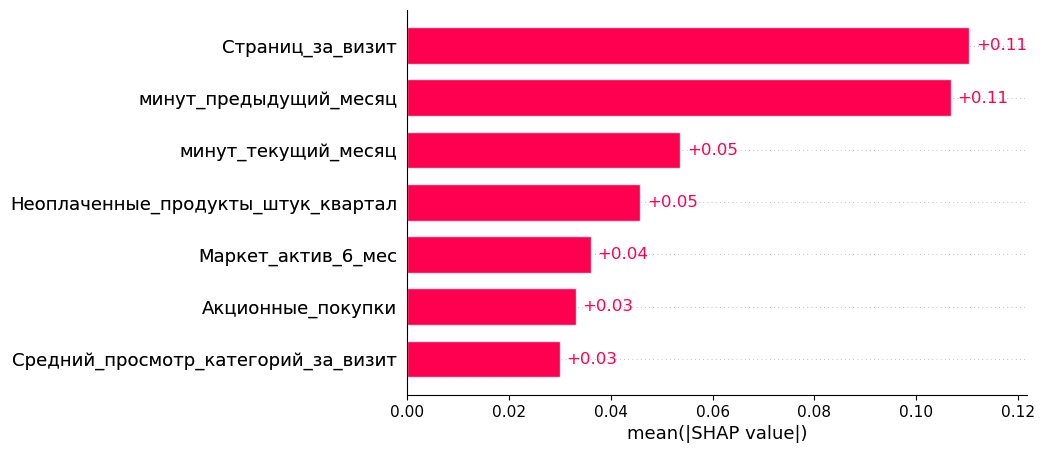

In [88]:
shap.plots.bar(shap_values[..., 1])

Наибольшую ценность для модели составляют среднее количество страниц, которые просмотрел покупатель за последние 3 месяца и количество минут, проведенное на сайте в предыдущем месяце.

Построим график влияния признаков на каждое предсказание. Положительным значениям шапли соответсвует снизившаяся активность покупателя. 

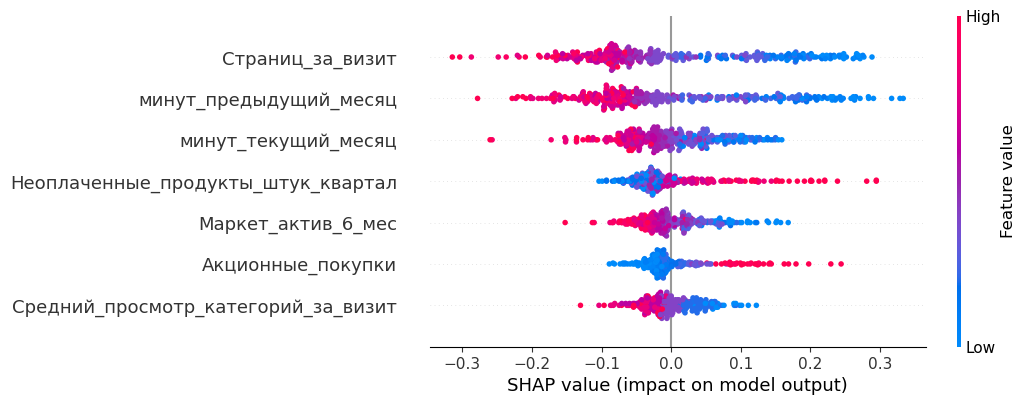

In [89]:
shap.plots.beeswarm(shap_values[:, :, 1])

Посморим на нескольк строк, которым модель неверно присвоила 0 класс.

In [90]:
X_test_new_df = X_test_new.copy()
X_test_new_df['y_true'] = y_test
X_test_new_df['y_prob'] = model.predict_proba(X_test_new)[:, 1]

y_bad = X_test_new_df.loc[(X_test_new_df['y_true'] == 1) & (X_test_new_df['y_prob'] < 0.3)]

print(len(y_bad))
      
y_bad.sort_values(by='y_prob').head(10)

56


Маркет_актив_6_мес  Акционные_покупки  \
112            0.431438          -0.797338   
170            0.134995          -0.210056   
227            1.419579          -0.758186   
138            0.431438          -0.444969   
218            1.123136          -0.679882   
310            0.332623          -0.327513   
191            1.419579           0.024857   
70             1.419579          -0.640730   
21             0.134995          -0.640730   
90            -0.161447          -0.366665   

     Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
112                             0.535870                           -0.443483   
170                             1.272787                            0.064024   
227                            -0.201046                           -0.950989   
138                             1.272787                            0.064024   
218                             1.272787                            0.064024   
310                             2.009703                            0.064024   
191                            -0.201046                            0.064024   
70                              1.272787                           -0.950989   
21                             -0.201046                           -0.443483   
90                              0.535870                           -0.443483   

     Страниц_за_визит  минут_текущий_месяц  минут_предыдущий_месяц  y_true  \
112          0.463814             0.415937               -0.358626     1.0   
170          0.212999             0.651853               -0.358626     1.0   
227         -0.037815             1.123684               -0.101144     1.0   
138          1.467072            -0.291809               -0.101144     1.0   
218          0.714629             0.887769                0.156338     1.0   
310          0.714629             0.651853                0.928784     1.0   
191          0.212999             1.123684               -0.358626     1.0   
70           0.212999            -0.763641               -0.873590     1.0   
21          -0.037815            -0.055894                0.671302     1.0   
90           0.714629            -1.471388                0.413820     1.0   

       y_prob  
112  0.053424  
170  0.055270  
227  0.058013  
138  0.059397  
218  0.061087  
310  0.065756  
191  0.068382  
70   0.075711  
21   0.078396  
90   0.079464

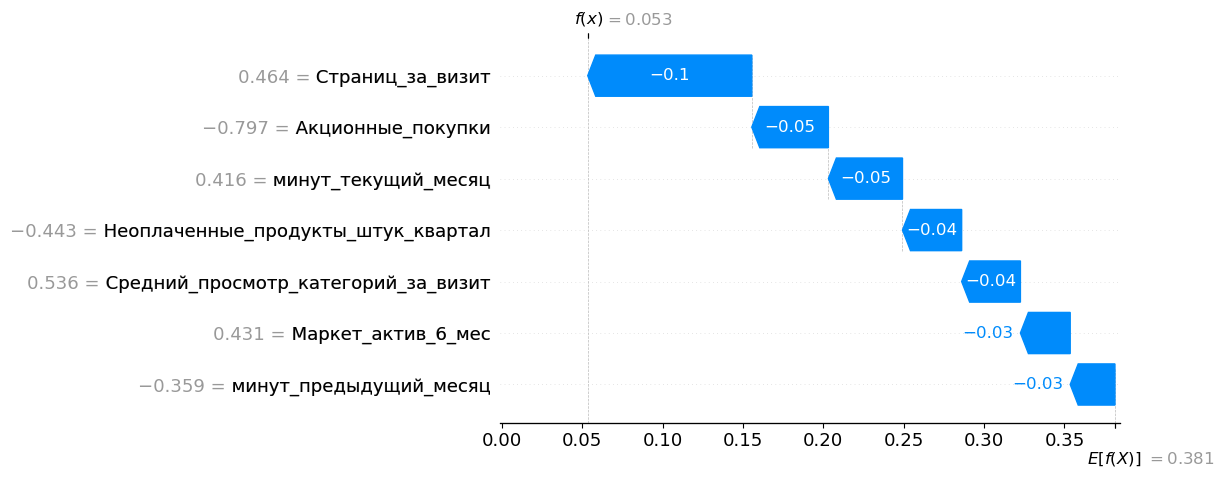

In [91]:
shap.plots.waterfall(shap_values[112, :, 1])

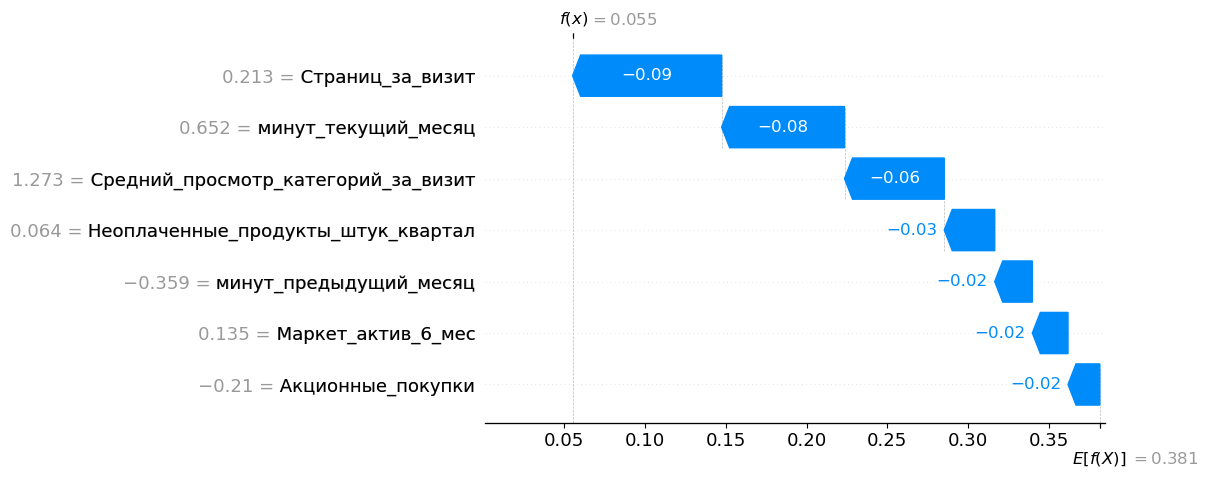

In [92]:
shap.plots.waterfall(shap_values[170, :, 1])

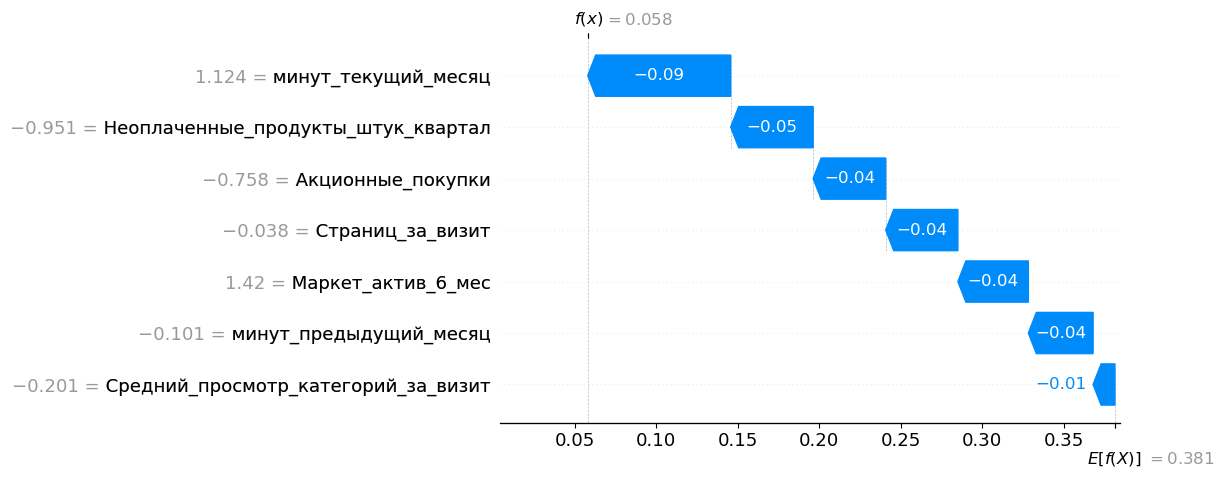

In [93]:
shap.plots.waterfall(shap_values[227, :, 1])

In [94]:
y_bad.sort_values(by='y_prob', ascending=False).head()

Маркет_актив_6_мес  Акционные_покупки  \
261           -0.951960          -0.836490   
229            1.221950           2.452288   
219           -0.457889          -0.249208   
199            0.036181          -0.288360   
212           -0.754332          -0.405817   

     Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
261                             0.535870                           -0.950989   
229                            -0.937962                           -1.458496   
219                            -1.674878                           -1.458496   
199                            -0.937962                            0.064024   
212                             1.272787                           -0.950989   

     Страниц_за_визит  минут_текущий_месяц  минут_предыдущий_месяц  y_true  \
261          0.714629             0.180022               -1.646036     1.0   
229          0.714629             1.123684                1.186266     1.0   
219          1.216258             0.180022               -0.616108     1.0   
199         -1.041073             0.415937                0.671302     1.0   
212         -0.539444             1.359600               -1.646036     1.0   

       y_prob  
261  0.295502  
229  0.292609  
219  0.264977  
199  0.255024  
212  0.218119

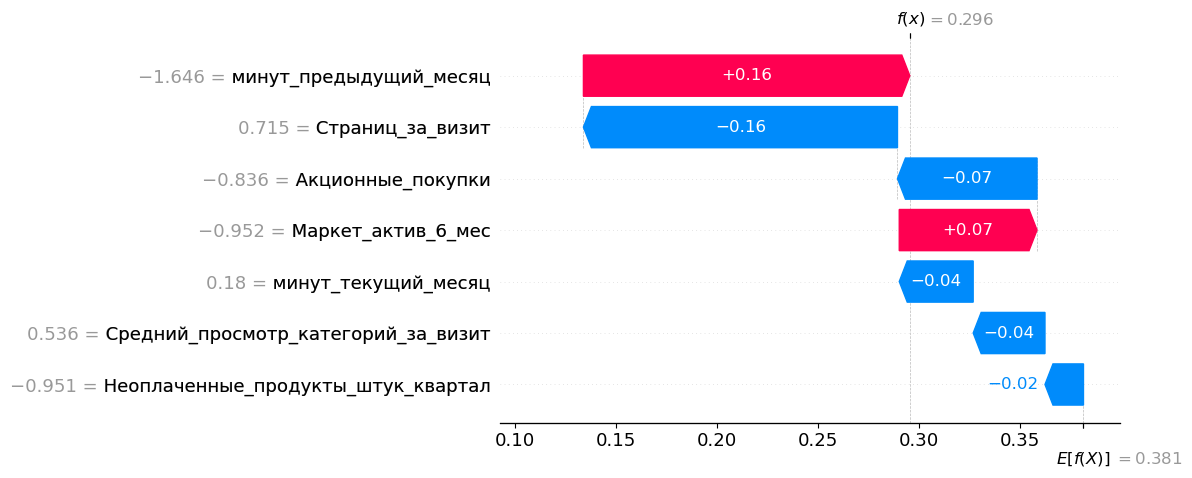

In [95]:
shap.plots.waterfall(shap_values[261, :, 1])

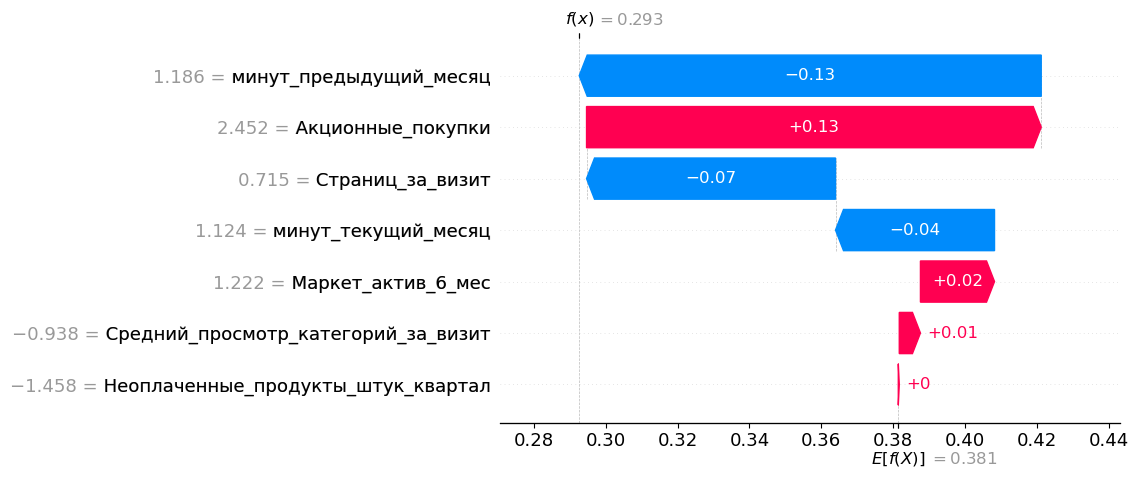

In [96]:
shap.plots.waterfall(shap_values[229, :, 1])

Каких то закономерностей в графиках неверно предсказанных значений выделить не могу.

### Вывод

Наиболее значимыми для модели являются следующие признаки:
- Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца;
- Количество минут, проведенное на сайте в предыдущем месяце;
- Количество минут, проведенное на сайте в текущем месяце;
- Общее число неоплаченных товаров в корзине за последние 3 месяца;
- Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев;
- Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
- Среднее количество просмотренных категорий за визит в последнем месяце.

Остальные признаки оказывали меньшее влияние на целевой признак.

По графику влияния признаков на каждое предсказание можно сделать выводы:

1. Малое значение просмотренных страниц и категорий, количество минут проведенное на сайте в текущем и предыдущих месяцах сведельствуют о снижении покупательской активности;
2. Большое количество неоплаченых продуктов в корзине и большая доля покупок по акции у покупателя говорит о том, что активность таких покупателей снизилась;
3. Количество маркетинговых активностей имеет влияние на активность покупателей. Когда их много, это помогает сохранить покупательскую активность, а малое число наоборот снижает эту активность;

По пунктам выше можно сделать вывод, что увеличение маркетинговых активностей, рассылок писем, звонков и т.д. может помочь в удержании активности покупателей. Увеличение количества различных акций поможем удержать клиентов, которые чаще совершают акционные покупки и, возможно, тех, кто держит много неоплаченных товаров в корзине. По неоплаченным продуктам в корзине, можно провести дополнительный анализ, который поможет выявить в них некоторые закономерности, например цена на некоторые товары или категории товаров могут быть завышены и люди ждут снижения цен на них. Имеет смысл также проанализировать удобство сайта, возможно это позволит увеличить время, которое покупатели проводят на сайте, что может положительно скахаться на их покупательской активности.

## Сегментация покупателей

Проанализируем группу покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Долю покупок по акции примем больше 0,8, а вероятность снижения активности больше 0,9.

In [148]:
df_segment_train = X_train[model.feature_names_in_].copy()
df_segment_train['y_pred'] = model.predict_proba(X_train_new)[:, 1]

In [149]:
df_segment_test = X_test[model.feature_names_in_].copy()
df_segment_test['y_pred'] = model.predict_proba(X_test_new)[:, 1]

In [150]:
df_segment = pd.concat([df_segment_train, df_segment_test])

In [151]:
df_segment.head()

Маркет_актив_6_мес  Акционные_покупки  \
1062                 4.8               0.11   
56                   2.4               0.94   
769                  4.2               0.30   
653                  5.3               0.17   
64                   2.9               0.90   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1062                                    6                                   1   
56                                      4                                   1   
769                                     5                                   5   
653                                     4                                   2   
64                                      1                                   5   

      Страниц_за_визит  минут_текущий_месяц  минут_предыдущий_месяц    y_pred  
1062                12                   23                      21  0.139282  
56                   3                   13                      12  0.948724  
769                 19                    9                      20  0.154789  
653                 11                   13                      12  0.053772  
64                   4                    9                      10  0.990668

In [154]:
df_segment_promo = df_segment.loc[(df_segment['y_pred'] >= 0.9) & (df_segment['Акционные_покупки'] >= 0.8)]

In [155]:
df_segment_promo.shape

(114, 8)

In [158]:
df_segment_promo.head()

Маркет_актив_6_мес  Акционные_покупки  \
56                 2.4               0.94   
64                 2.9               0.90   
26                 2.9               0.98   
97                 4.0               0.99   
41                 4.1               0.93   

    Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
56                                    4                                   1   
64                                    1                                   5   
26                                    6                                   3   
97                                    1                                   6   
41                                    5                                   2   

    Страниц_за_визит  минут_текущий_месяц  минут_предыдущий_месяц    y_pred  
56                 3                   13                      12  0.948724  
64                 4                    9                      10  0.990668  
26                 2                    8                      11  0.965650  
97                 5                   10                       9  0.981675  
41                 7                    7                       7  0.974911

В новый датасет попало 114 покупателей.

Посмотрим, как отличалось количество минут, проведенные на сайте в прошлый и в текущий месяцы.

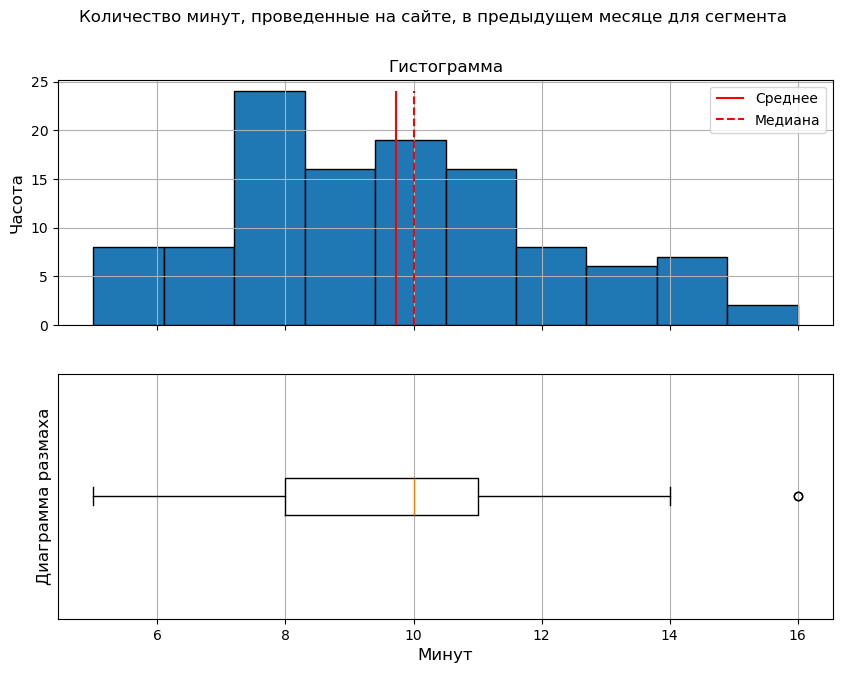

count    114.000000
mean       9.719298
std        2.317722
min        5.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       16.000000
Name: минут_предыдущий_месяц, dtype: float64


In [177]:
hist_box_plot(
    df_segment_promo['минут_предыдущий_месяц'], 
    bins=10, 
    title='Количество минут, проведенные на сайте, в предыдущем месяце для сегмента', 
    x_lable='Минут'
)

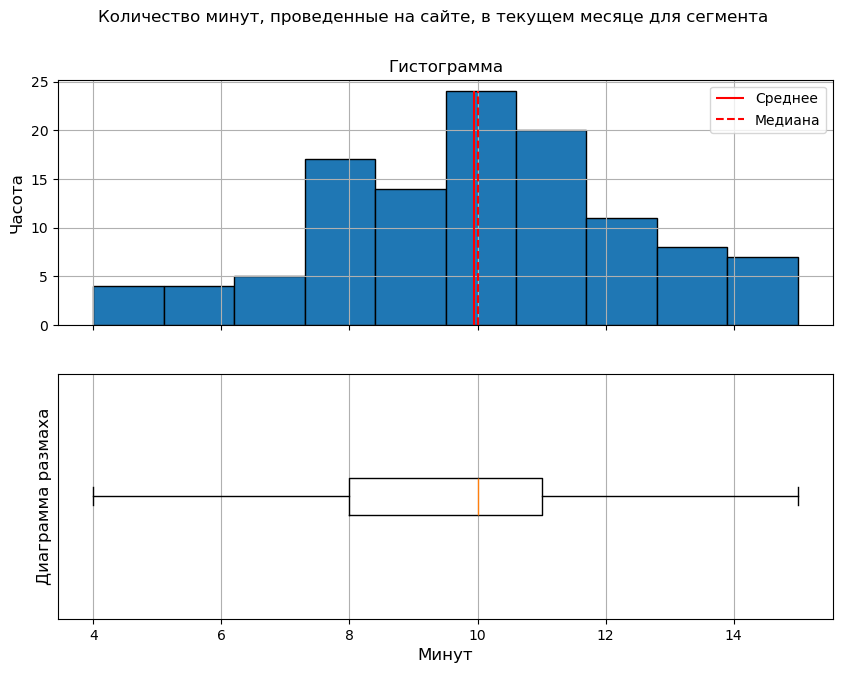

count    114.000000
mean       9.947368
std        2.245318
min        4.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       15.000000
Name: минут_текущий_месяц, dtype: float64


In [192]:
hist_box_plot(
    df_segment_promo['минут_текущий_месяц'], 
    bins=10, 
    title='Количество минут, проведенные на сайте, в текущем месяце для сегмента', 
    x_lable='Минут'
)

Активность за оба месяца особо не различается. Посмотрим, как отличаются данные от общей выборки.

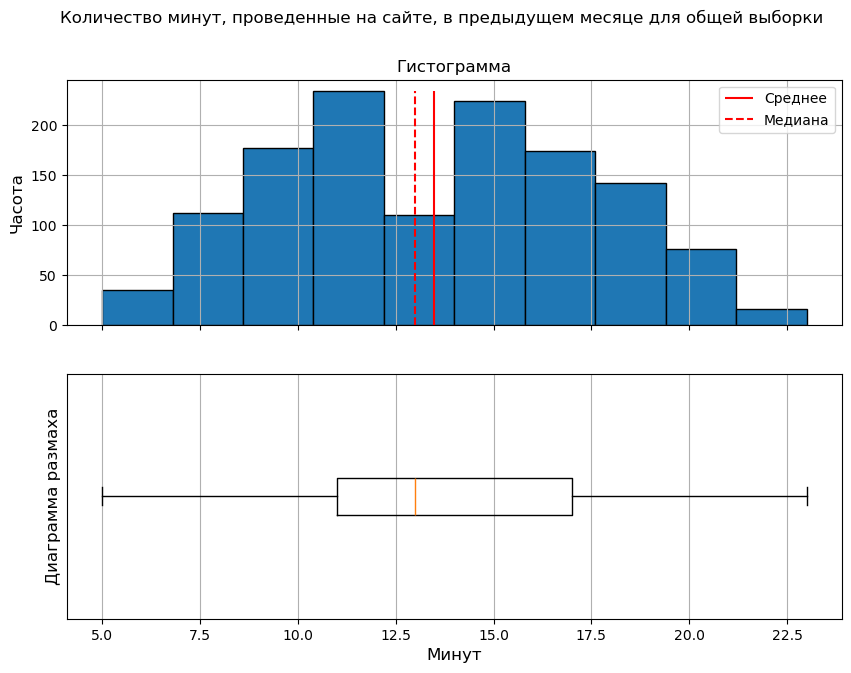

count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: минут_предыдущий_месяц, dtype: float64


In [193]:
hist_box_plot(
    data_market['минут_предыдущий_месяц'], 
    bins=10, 
    title='Количество минут, проведенные на сайте, в предыдущем месяце для общей выборки', 
    x_lable='Минут'
)

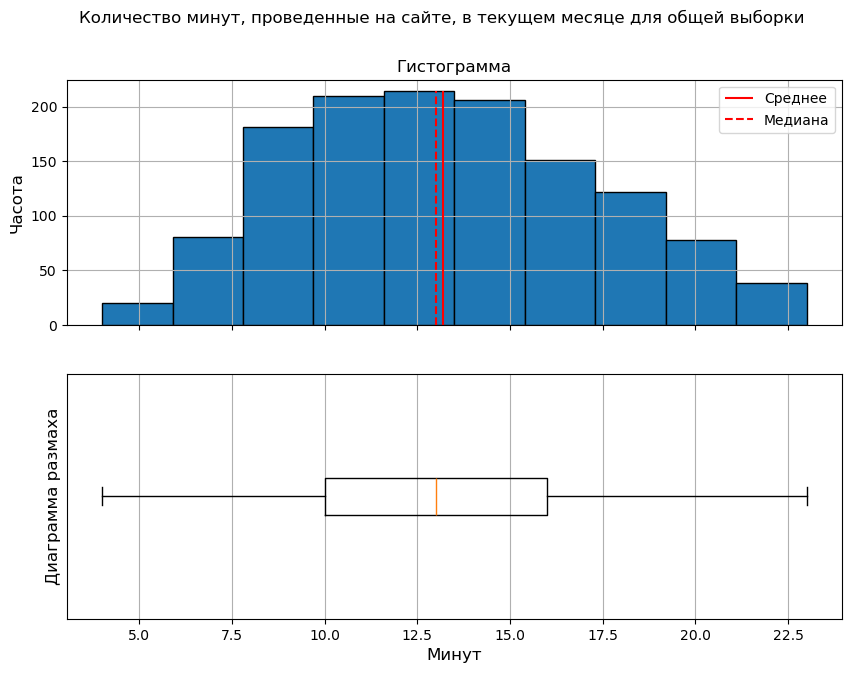

count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут_текущий_месяц, dtype: float64


In [194]:
hist_box_plot(
    data_market['минут_текущий_месяц'], 
    bins=10, 
    title='Количество минут, проведенные на сайте, в текущем месяце для общей выборки', 
    x_lable='Минут'
)

Покупатели в прошлом и текущем месяце в среднем проводили на сайте около 13 минут, а покупатели из сегмента около 10.

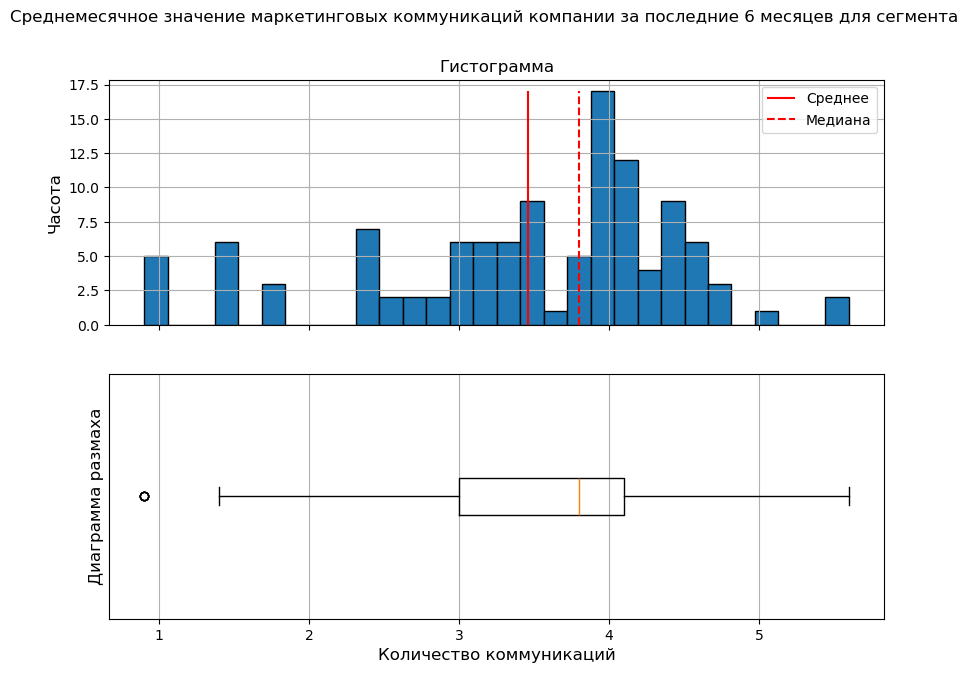

count    114.000000
mean       3.458772
std        1.049636
min        0.900000
25%        3.000000
50%        3.800000
75%        4.100000
max        5.600000
Name: Маркет_актив_6_мес, dtype: float64


In [179]:
hist_box_plot(
    df_segment_promo['Маркет_актив_6_мес'], 
    bins=30, 
    title='Среднемесячное значение маркетинговых коммуникаций компании за последние 6 месяцев для сегмента', 
    x_lable='Количество коммуникаций'
)

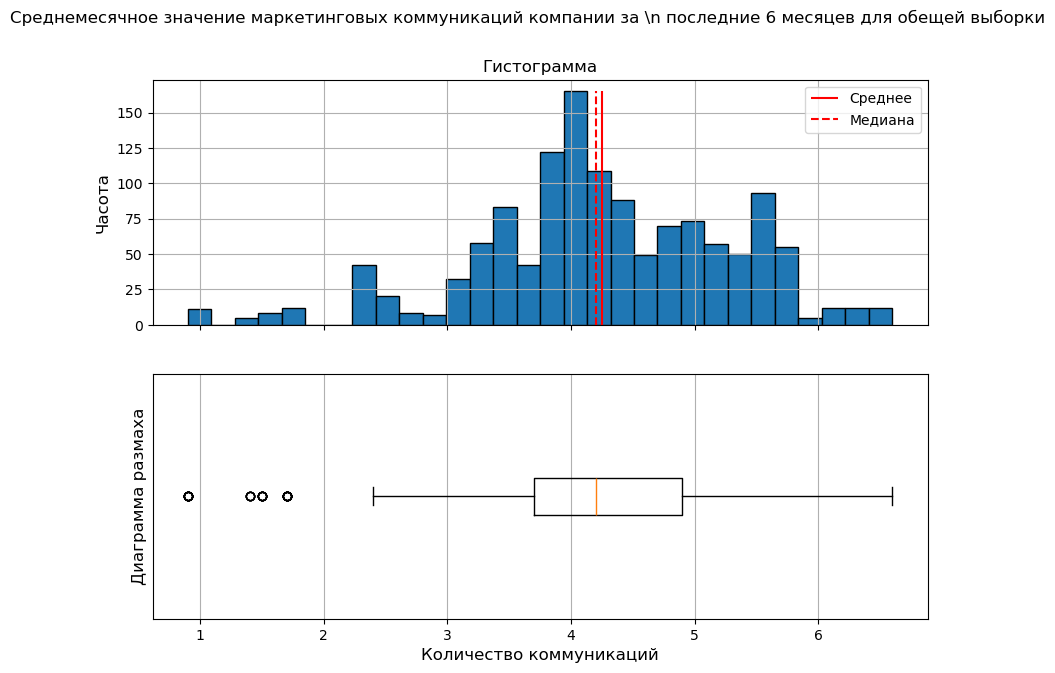

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


In [196]:
hist_box_plot(
    data_market_file['Маркет_актив_6_мес'], 
    bins=30, 
    title='Среднемесячное значение маркетинговых коммуникаций компании за последние 6 месяцев для обещей выборки', 
    x_lable='Количество коммуникаций'
)

В среднем у покупателей из сегмента было меньше маркентинговых взаимодействий с сайтом, чем у покупателей из общей выборки.

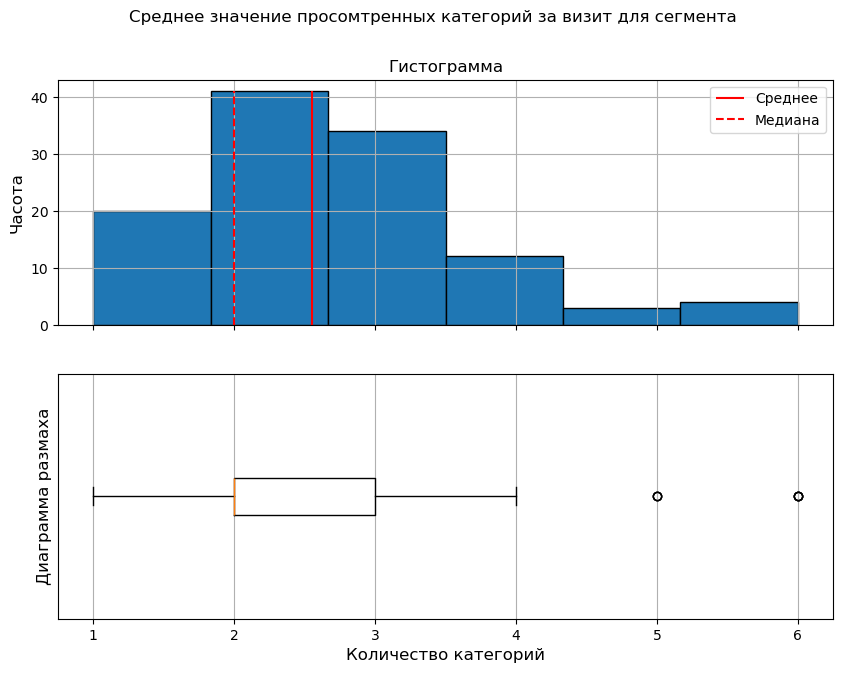

count    114.000000
mean       2.552632
std        1.183157
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


In [180]:
hist_box_plot(
    df_segment_promo['Средний_просмотр_категорий_за_визит'], 
    bins=6, 
    title='Среднее значение просомтренных категорий за визит для сегмента', 
    x_lable='Количество категорий'
)

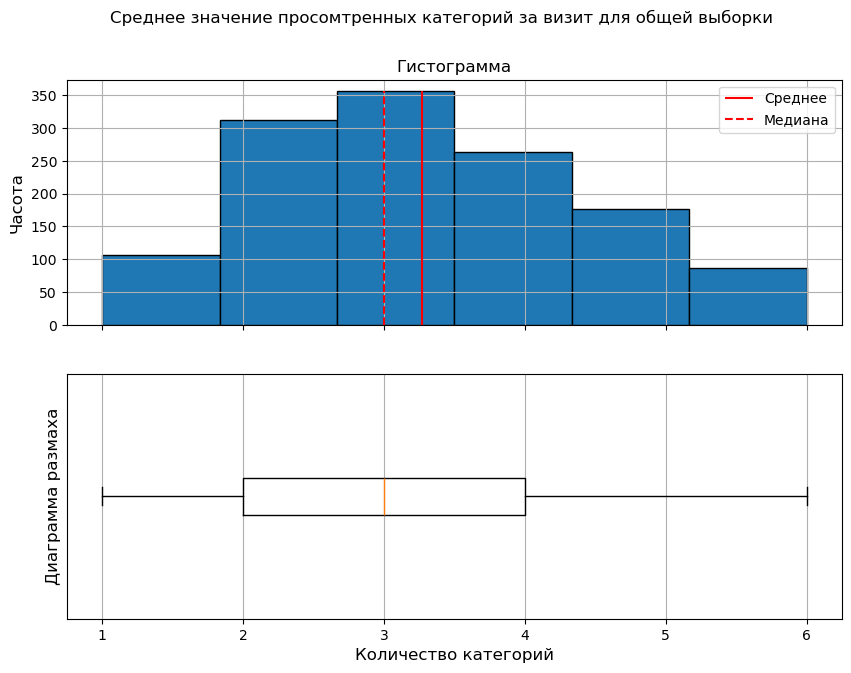

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


In [197]:
hist_box_plot(
    data_market_file['Средний_просмотр_категорий_за_визит'], 
    bins=6, 
    title='Среднее значение просомтренных категорий за визит для общей выборки', 
    x_lable='Количество категорий'
)

Покупатели из сегмента просматривали в среднем за визит меньше категорий, чем покупатели из общей выборки. Эти данные коррелируют с данными о минутах проведенных на сайте.

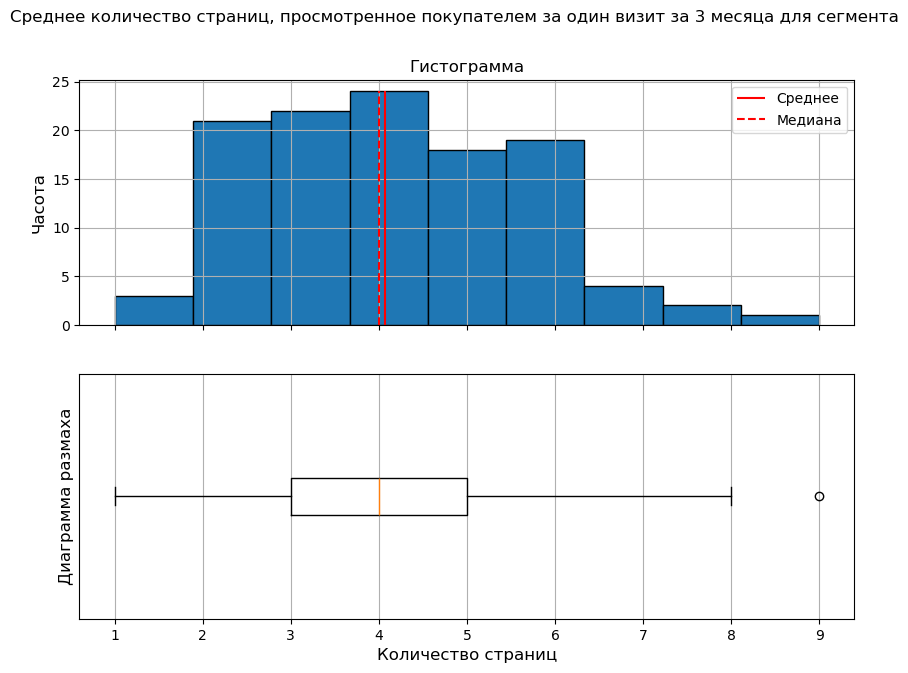

count    114.000000
mean       4.070175
std        1.681336
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: Страниц_за_визит, dtype: float64


In [184]:
hist_box_plot(
    df_segment_promo['Страниц_за_визит'], 
    bins=9, 
    title='Среднее количество страниц, просмотренное покупателем за один визит за 3 месяца для сегмента', 
    x_lable='Количество страниц'
)

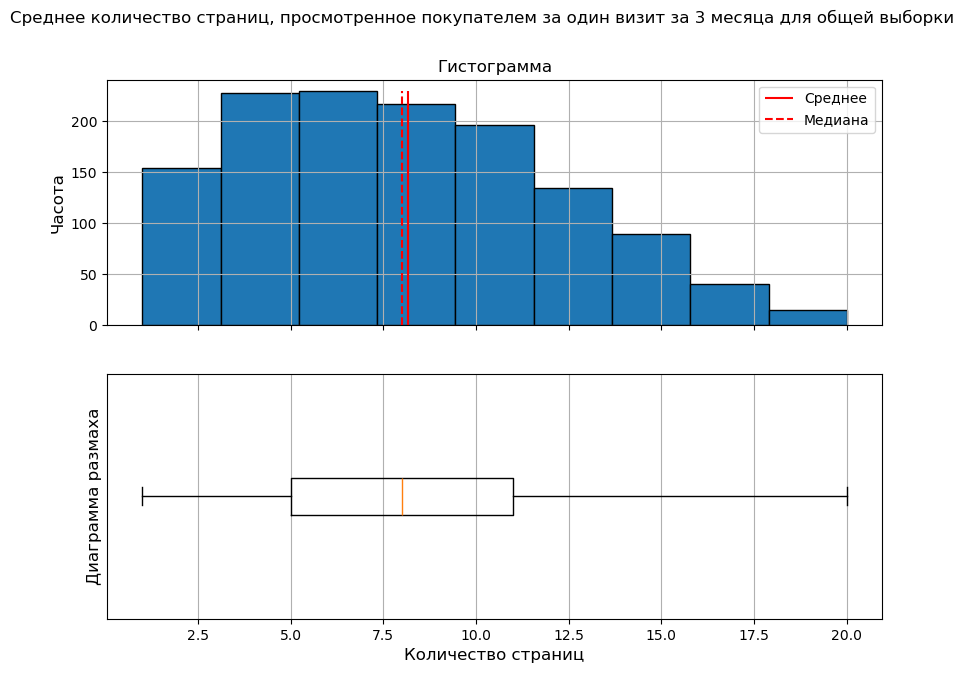

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64


In [185]:
hist_box_plot(
    data_market['Страниц_за_визит'], 
    bins=9, 
    title='Среднее количество страниц, просмотренное покупателем за один визит за 3 месяца для общей выборки', 
    x_lable='Количество страниц'
)

Среднее количество просмотренных страниц у сегмента покупателей отличается в целых 2 раза по сравнению с покупателями из общей выборке. Различия в этой категории сильно выше, чем различия в просмотренных категориях и минутах, проведенных на сайте. Вероятно, покупателям, которые часто совершают покупки по акции, тяжело найти интересные для себя товары.

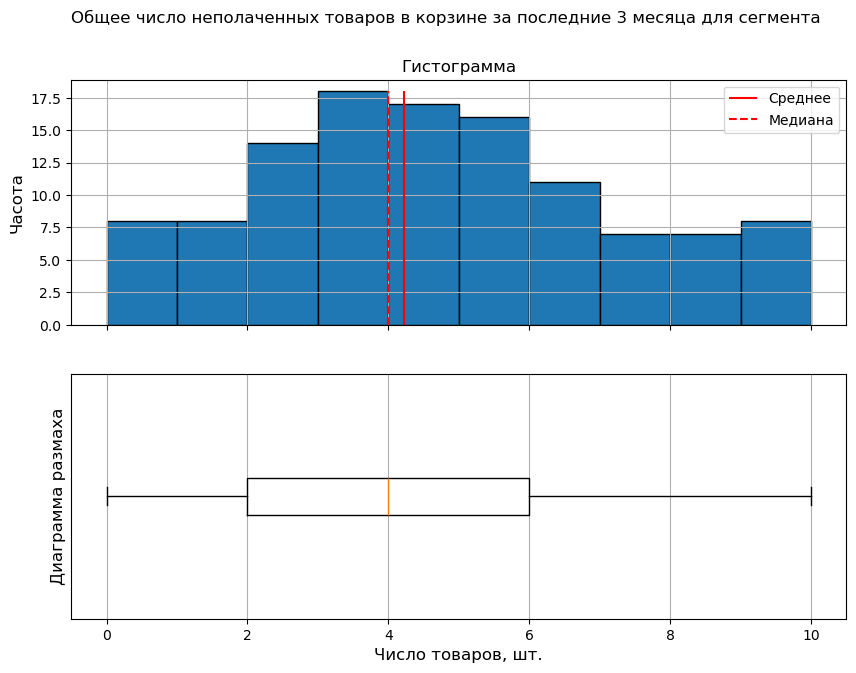

count    114.000000
mean       4.228070
std        2.513803
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


In [190]:
hist_box_plot(
    df_segment_promo['Неоплаченные_продукты_штук_квартал'], 
    bins=10, 
    title='Общее число неполаченных товаров в корзине за последние 3 месяца для сегмента', 
    x_lable='Число товаров, шт.'
)

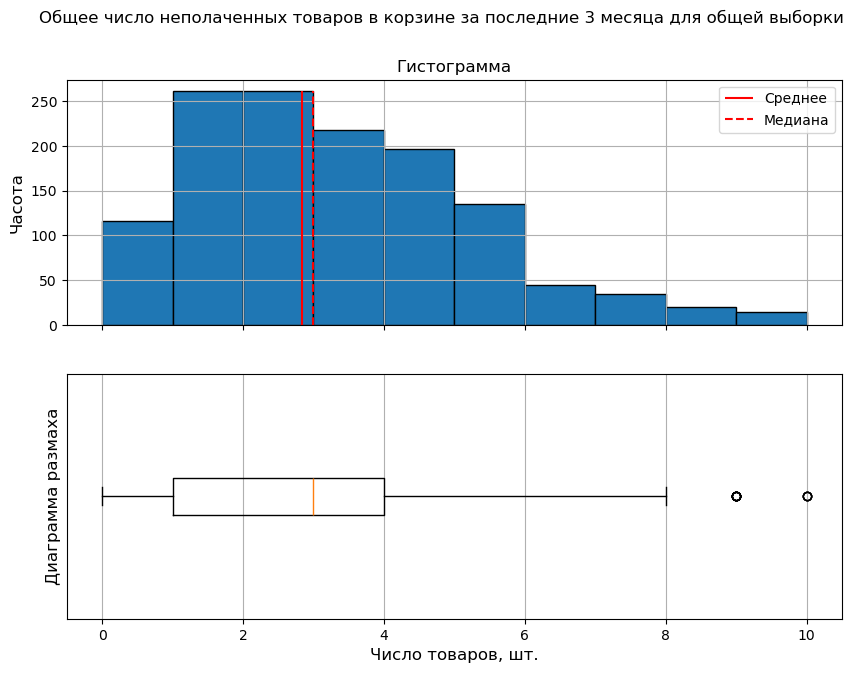

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


In [191]:
hist_box_plot(
    data_market['Неоплаченные_продукты_штук_квартал'], 
    bins=10, 
    title='Общее число неполаченных товаров в корзине за последние 3 месяца для общей выборки', 
    x_lable='Число товаров, шт.'
)

Число неоплаченных продуктов в корзине у сегмента покупателей, которые предпочитают покупки по акции, тоже сильно отличается от общей выборки, практически в 1,5 раза.

### Вывод

В рамках работы был проведен анализ категории покупателей, которые совершают преимущественно покупки по акции и имеют снизившуюся покупательскую активность. 

Мои предложения по работе с данным сегментов покупателей:

- Кол-во минут проведенных на сайте у покупателей из сегмента меньше, (примерно на треть) чем у покупателей из общей выборки. Это можно списать на то, что в сегменте представлены только покупатели со снизившейся покупательской активностью. При этом стоило ожидать такого же отклонения в процентом соотношении в просмотренных категориях и страницах, но этого не происходит. Разница в просмотренных страницах у сегмента покупателей меньше вдвое, чем у покупателей из общей выборке. Это может говорить о том, что покупателям трудно найти на сайте товары, которые могут их заинтересовать. Мое предложения - добавить (или улучшить) систему рекомендаций для данной категории покупателей и улучшить пользовательский опыт во взаимодействии с сайтом, например добавить фильтр по акционным товарам в поиске, если таковой отсутствует.

- Количество маркетинговых взаимодейтвий у анализируемого сегмента покупателей ниже, чем у покупателей из общей выборки. Стоит увеличить количество таких взаимодействий с данным сегментом, например делать больше рассылок с акционными товарами. Этот показатель неплохо влияет на удержание клиентов из общей выборки, и он должен быть особенно важен при взаимодействии с клиентами, которых интересуют акции.

- Допольнительно стоит провести анализ неоплаченных товаров в корзинах покупателей из данного сегмента. Анализ показывает, что у этих покупателей в 1,5 раза больше товаров в корзине, чем у покупателей из общей выборки. Учитывая, что товары в корзине могут лежать в ожиданни скидок, стоит ввести дополнительные уведомления покупателей, когда эти товары получают в магахине скидку.

## Вывод

В данной работе необходимо было обучить модель машнного обучения, которая предсказывает снижение покупательскй активности клиентов интернет-магазина, выделить один сегмент покупателей в интернет магазине и провести его анализ. В рамках анализа привести предложение по увеличению покупательской активности выбранного сегмента.

Для решения задачи обучения модели данные были предварительно обработаны и подготовлены для для дальнейшего использования для обучения модели. 

Для поиска лучшей модели машинного обучения был разработан пайплайн, который перебирал различные комбинации моделей, их гиперпараметров и способы масштабирования численных признаков.

Модели, которые участвовали в пайплайне: 
- Логистическая регрессия;
- Метод опорных веторов;
- Метод k-ближайших соседей;
- Дерево решений.

Лучшая модель и ее гиперпараметры:
- Модель SVC (метод опорных векторов);
- Ядро модели - rbf;
- Параметр C = 1;
- Метод масштабирования численных столбцов - стандартизация.

Для лучшей модели был проведен анализ важности принаков по результатам которого модель достигла лучших показателей со следующими столбцами:
- Маркет_актив_6_мес;
- Акционные_покупки;
- Средний_просмотр_категорий_за_визит;
- Неоплаченные_продукты_штук_квартал;
- Страниц_за_визит;
- минут_текущий_месяц;
- минут_предыдущий_месяц.

В рамках анализа сегмента покупателей был проанализирован сегмент покупателей, которые совершают большую часть покупок по акции и имеют снизившуюся покупательскую активность. В рамках анализа были приведены графики, описывающие данный сегмент покупателей и сделаны выводы. Предложения по увеличвению покупательской активности данного сегмента:

- Добавление или улучшение системы рекомендаций для данной категории покупателей и улучшение пользовательского опыта во взаимодействии с сайтом, например добавление фильтра по акционным товарам в поиске, если таковой отсутствует;
-  Увеличение количества маркентиговых взаимодействий с покупателями из данного сегмента: больше рассылок с акционными товарами, звонков и т.д.
- Проведение дополнительного анализа неоплаченных товаров в корзинах у покупателей из данного сегмента.